In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import textwrap

from pydmd import DMD

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../../python/")
sys.path.append("../")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2024-01-09 08:47:34.647051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 08:47:34.768817: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 08:47:34.773285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-09 08:47:34.773305: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/2015/../../python/hasnain_DMD.py'>

# Load Data

In [2]:
data_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT and ribosomal genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]
rp_genes = [x for x in all_genes if x.startswith('RP')]

print(f"{df.shape=}")
df = df.drop(mt_genes) # drop MT genes
df = df.drop(rp_genes) # drop ribosomal genes
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)
print(f"{gf.shape=}")


df.head()

df.shape=(19393, 18)
df.shape=(19235, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19235


/tmp/ipykernel_998270/4036917658.py:23: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(gene_path, gene_names)


gf.shape=(19235, 2)


,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A1BG,12,5,5,9,2,6,7,3,6,5,5,5,4,3,4,5,5,3
A1CF,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,0,0,0
A2M,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,2
A2ML1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Choose Rank = 7; TPM > 0.5

In [3]:
target = 1e6
threshold = 0.5
rank = 7
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
mask = (tpm_dist > threshold)
high_exp_genes = tpm_dist[mask].index.to_list()    

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data = nb.data2DMD(d) 
print(f"{dmd_data.shape=}")

outpath = "../../data/2015_data/2015_rep1.txt"
np.savetxt(outpath, dmd_data[:, :, 0])

outpath = "../../data/2015_data/2015_rep2.txt"
np.savetxt(outpath, dmd_data[:, :, 1])

outpath = "../../data/2015_data/2015_genes.txt"
np.savetxt(outpath, d.index, fmt="%s")

dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dmd_data.shape=(8112, 8, 2)
dmd_res['A'].shape=(8112, 8112)
dmd_res['Atilde'].shape=(7, 7)
dmd_res['u_r'].shape=(8112, 7)
dmd_res['L'].shape=(7,)
dmd_res['W'].shape=(7, 7)
dmd_res['Phi'].shape=(8112, 7)
dmd_res['amplitudes'][0].shape=(7, 8)
done


np.real(L).max()=0.9916712386196376
pdf.shape=(7, 2)


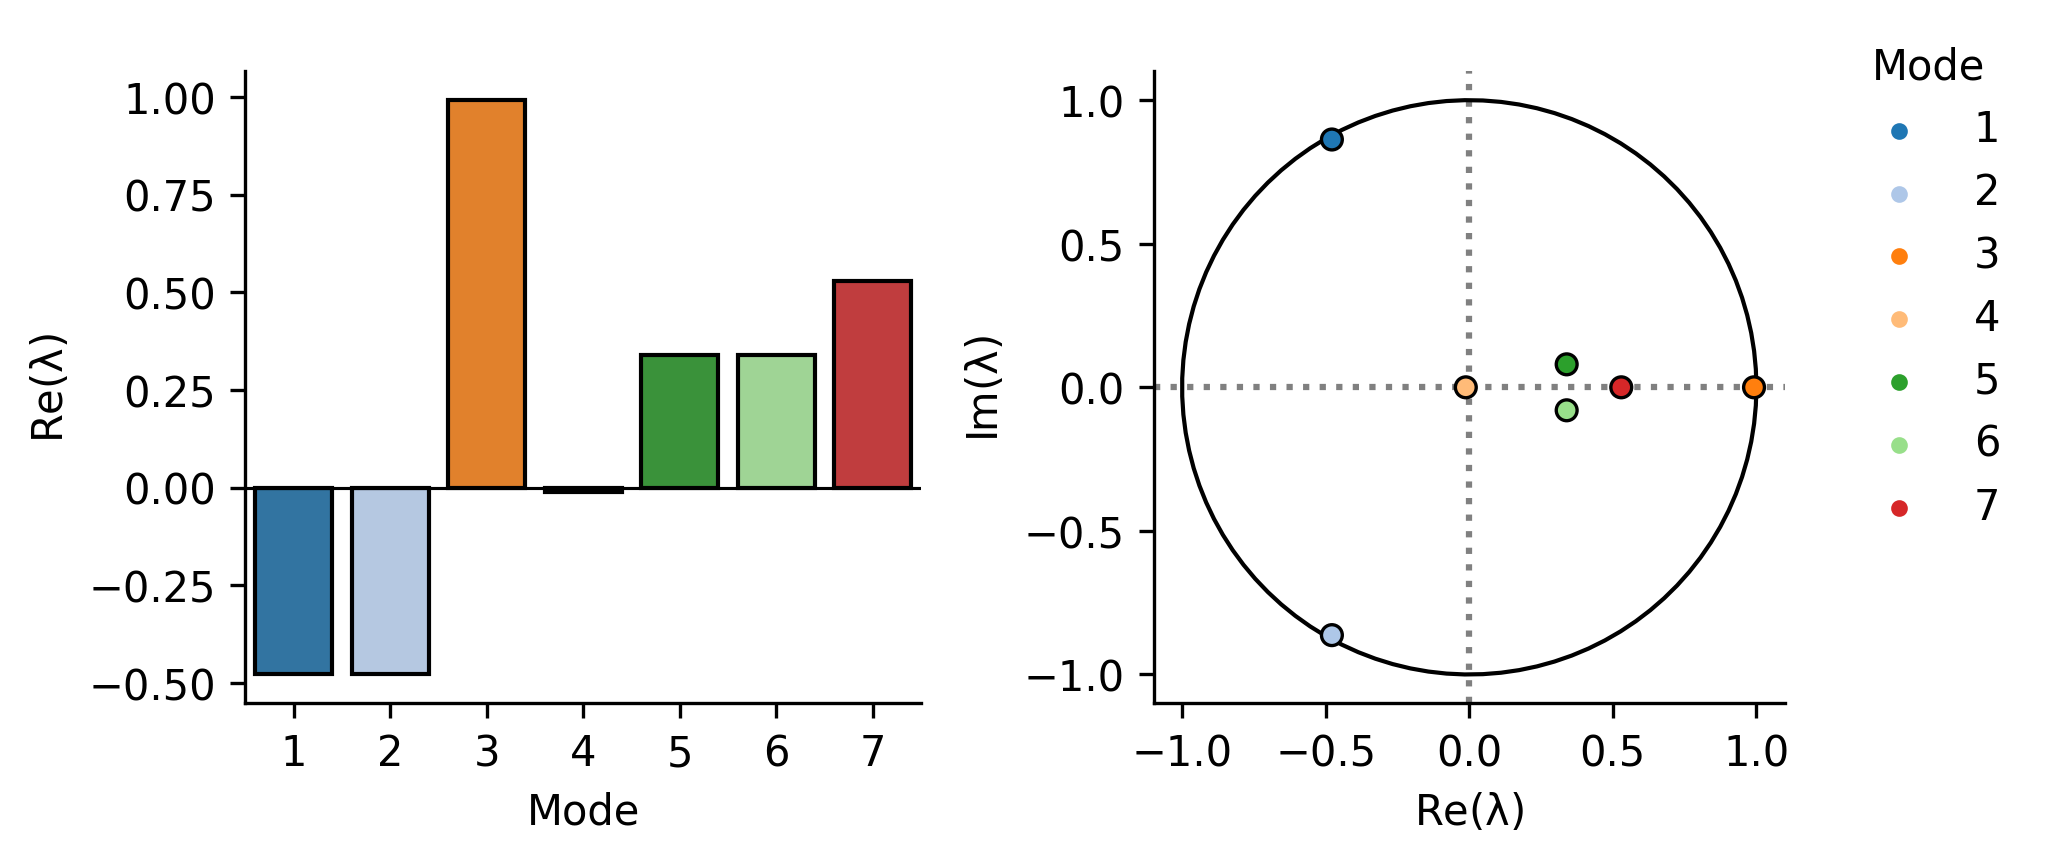

In [4]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3

fig, axs = plt.subplots(1, 2)

L = dmd_res['L']
print(f"{np.real(L).max()=}")
pdf = pd.DataFrame({'real' : np.real(L),
                    'imaginary' : np.imag(L)})

print(f"{pdf.shape=}")
pdf['mode'] = list(range(1, len(pdf)+1))

# plot real parts
sns.barplot(data=pdf, 
            x='mode',
            y='real',
            hue='mode',
            ax=axs[0],
            dodge=False,
            ec='k',
            palette='tab20',)

axs[0].legend().remove()

axs[0].axhline(y=0, zorder=1, lw=0.75, c='k')
axs[0].set_xlabel("Mode")
axs[0].set_ylabel(r'$\mathregular{Re(\lambda)}$')


# plot the eigenvalues
# make the unit circle
axs[1].plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

sns.scatterplot(data=pdf,
                x='real', 
                y='imaginary',
                s=100,
                marker=".",
                # legend=False,
                hue='mode',
                ax=axs[1],
                ec='k',
                palette='tab20',
                zorder=3)

# add the axis
axs[1].axvline(x=0, ls=":", c='grey', zorder=0)
axs[1].axhline(y=0, ls=":", c='grey', zorder=0)

axs[1].set_aspect('equal')
axs[1].set_xlabel(r'$\mathregular{Re(\lambda)}$')
axs[1].set_ylabel(r'$\mathregular{Im(\lambda)}$')

sns.move_legend(axs[1], 
                title='Mode',
                frameon=False, 
                loc='upper right',
                markerscale=0.5,
                bbox_to_anchor=(1.4, 1.1))


sns.despine()
plt.tight_layout()

In [5]:
outpath = "../../data/2015_data/A.txt"
np.savetxt(outpath, dmd_res['A'])
print('done')

done


In [6]:
outpath = "../../data/2015_data/control_timepoint.csv"
d[['S1a', 'S1b']].to_csv(outpath)
d[['S1a', 'S1b']].head()

,S1a,S1b
geneName,,
A4GALT,0.728128,0.629071
AAAS,2.684803,2.711166
AACS,0.859995,0.822024
AAGAB,1.259756,1.273046
AAMP,15.521382,15.625681


In [7]:
d.head()

,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A4GALT,0.728128,0.629071,0.472031,0.515156,0.523757,0.548982,0.479790,0.529386,0.435893,0.419155,0.540279,0.637680,0.581729,0.572130,0.459156,0.325065,0.631822,0.533986
AAAS,2.684803,2.711166,3.287762,3.548200,3.284197,3.295556,2.398563,2.221554,2.882785,2.674720,2.995194,2.933435,2.426814,2.348625,3.348397,3.501258,2.842093,3.132419
AACS,0.859995,0.822024,0.818799,0.730976,0.659868,0.649130,0.814887,0.732596,0.828100,0.914619,0.830217,0.809711,0.742738,0.812148,0.755614,0.816477,0.740497,0.750778
AAGAB,1.259756,1.273046,1.436806,1.364192,1.258220,1.232621,1.310217,1.344992,1.393150,1.288104,1.146511,1.149491,1.063345,1.098117,0.956624,0.961782,0.983712,0.972340
AAMP,15.521382,15.625681,15.991591,15.052069,13.866394,13.913058,13.265243,13.408798,13.598188,13.686900,13.874603,14.853579,14.027852,12.816619,14.111038,14.293969,13.898976,12.415323


In [8]:
# break

# Visualize predictions

X_pred.shape=(8112, 8, 2) cd=0.8992675693233319


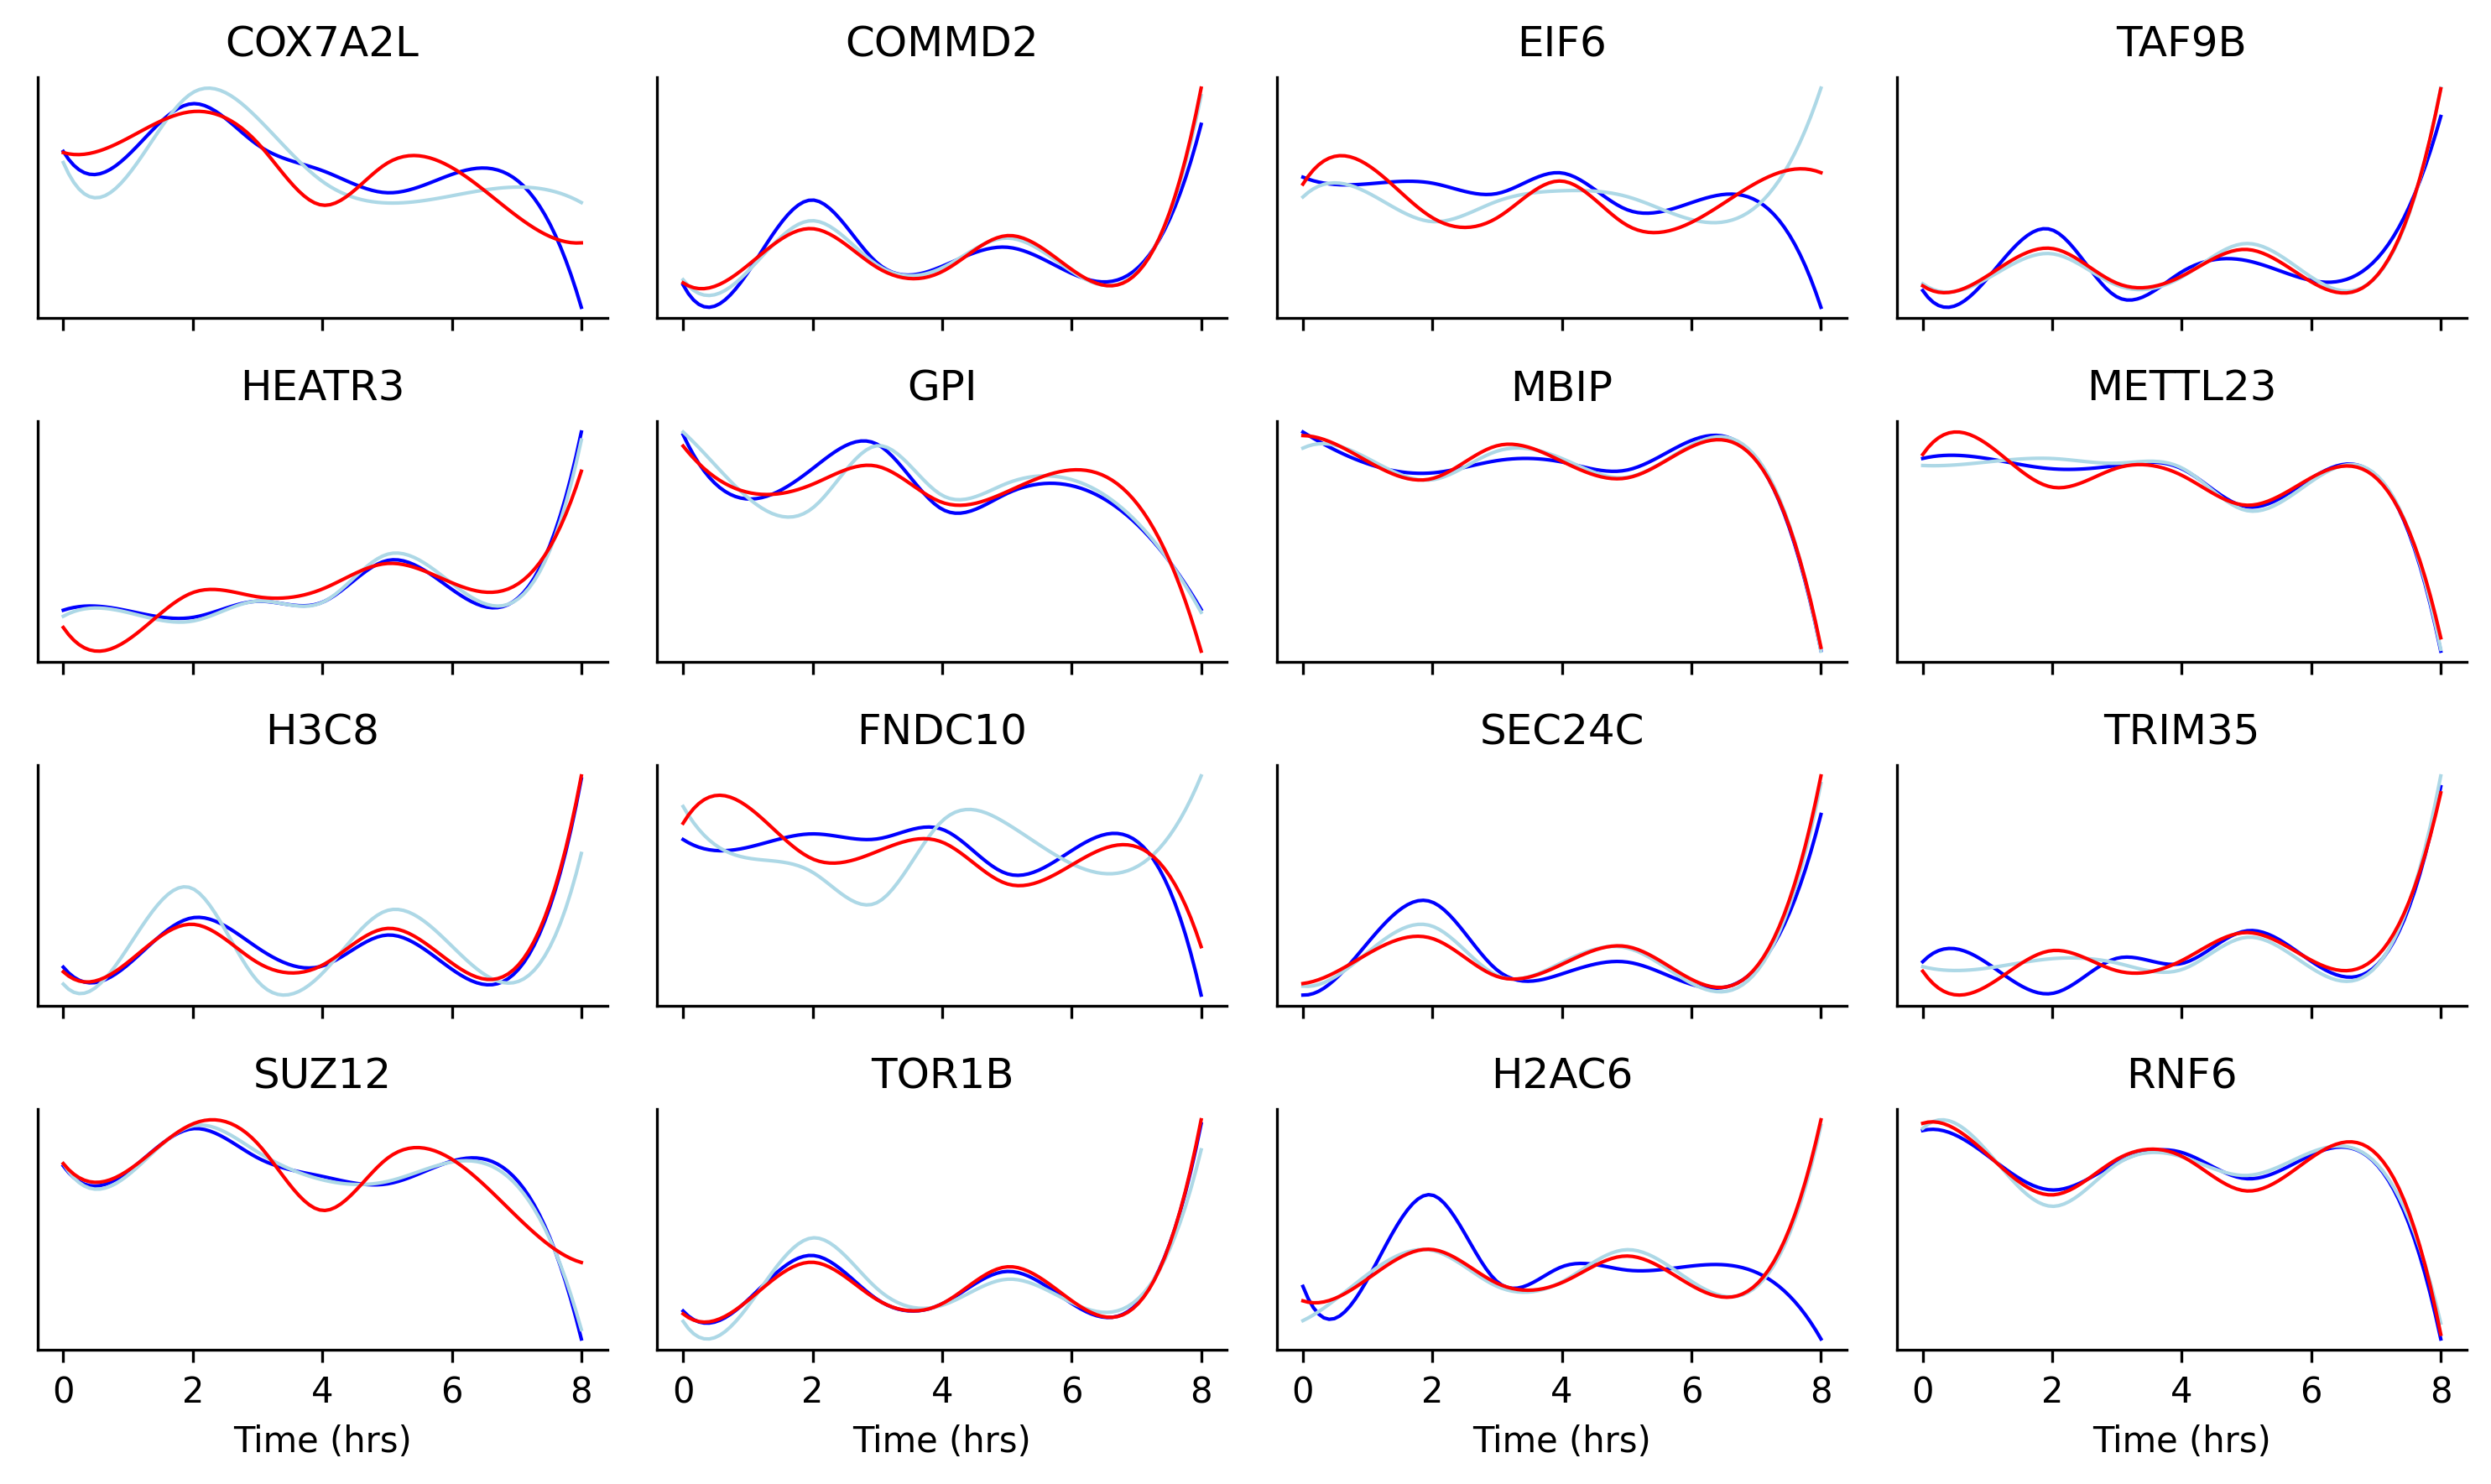

In [9]:
sample_size = 16

gene_labels = pd.DataFrame(high_exp_genes, columns=['gene_name'])
X_pred, cd = hasnain_DMD.get_predictions(dmd_res)

print(f"{X_pred.shape=} {cd=}")

genes = np.random.choice(high_exp_genes, sample_size, replace=False)
gene_ind = [high_exp_genes.index(x) for x in high_exp_genes if x in genes]

def smooth_columns(df, columns, xmin, xmax, n_points=100, power=3, standardize=True):
    """A function to smooth a column"""

    S = np.zeros((n_points, len(columns)))

    for i, column in enumerate(columns):
        y = df[column].to_numpy()
        x = list(range(len(y)))
        x_hat = np.linspace(0, len(y), n_points) 

        spl = make_interp_spline(x, y, k=power)  
        y_hat = spl(x_hat)
        if standardize:
            y_hat =  (y_hat - y_hat.mean())/(y_hat.std())

        S[:, i] = y_hat

    S = pd.DataFrame(S, index=x_hat, columns=columns)
    return S

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 6

fig, axs =  plt.subplots(4, 4, sharex=True)
axs = axs.ravel()

for i, ind in enumerate(gene_ind):
    gene_name = genes[i]

    pdf = pd.DataFrame(dmd_data[ind, :, :], columns=['r1', 'r2'])
    pdf['pred'] = X_pred[ind, :, :].mean(axis=1)
    
    pdf = pdf.reset_index(drop=False)
    pdf['hours'] = pdf['index'] * 8
    pdf = pdf.drop(columns='index')

    pdf = smooth_columns(pdf, ['r1', 'r2', 'pred'], xmin=0, xmax=56)
    pdf = pdf.reset_index(drop=False)
    pdf = pd.melt(pdf, id_vars=['index'])
    
    sns.lineplot(data=pdf,
                 x='index',
                 y='value',
                 hue='variable',
                 lw=1,
                 legend=False,
                 palette=['blue', 'lightblue','r'],
                 ax=axs[i])

    axs[i].set_ylabel("")
    axs[i].set_yticks([])
    axs[i].set_xlabel("Time (hrs)")
    axs[i].set_title(gene_name)

plt.tight_layout()
sns.despine()

# Get the "signature" of each mode

phi.shape=(8112, 7)


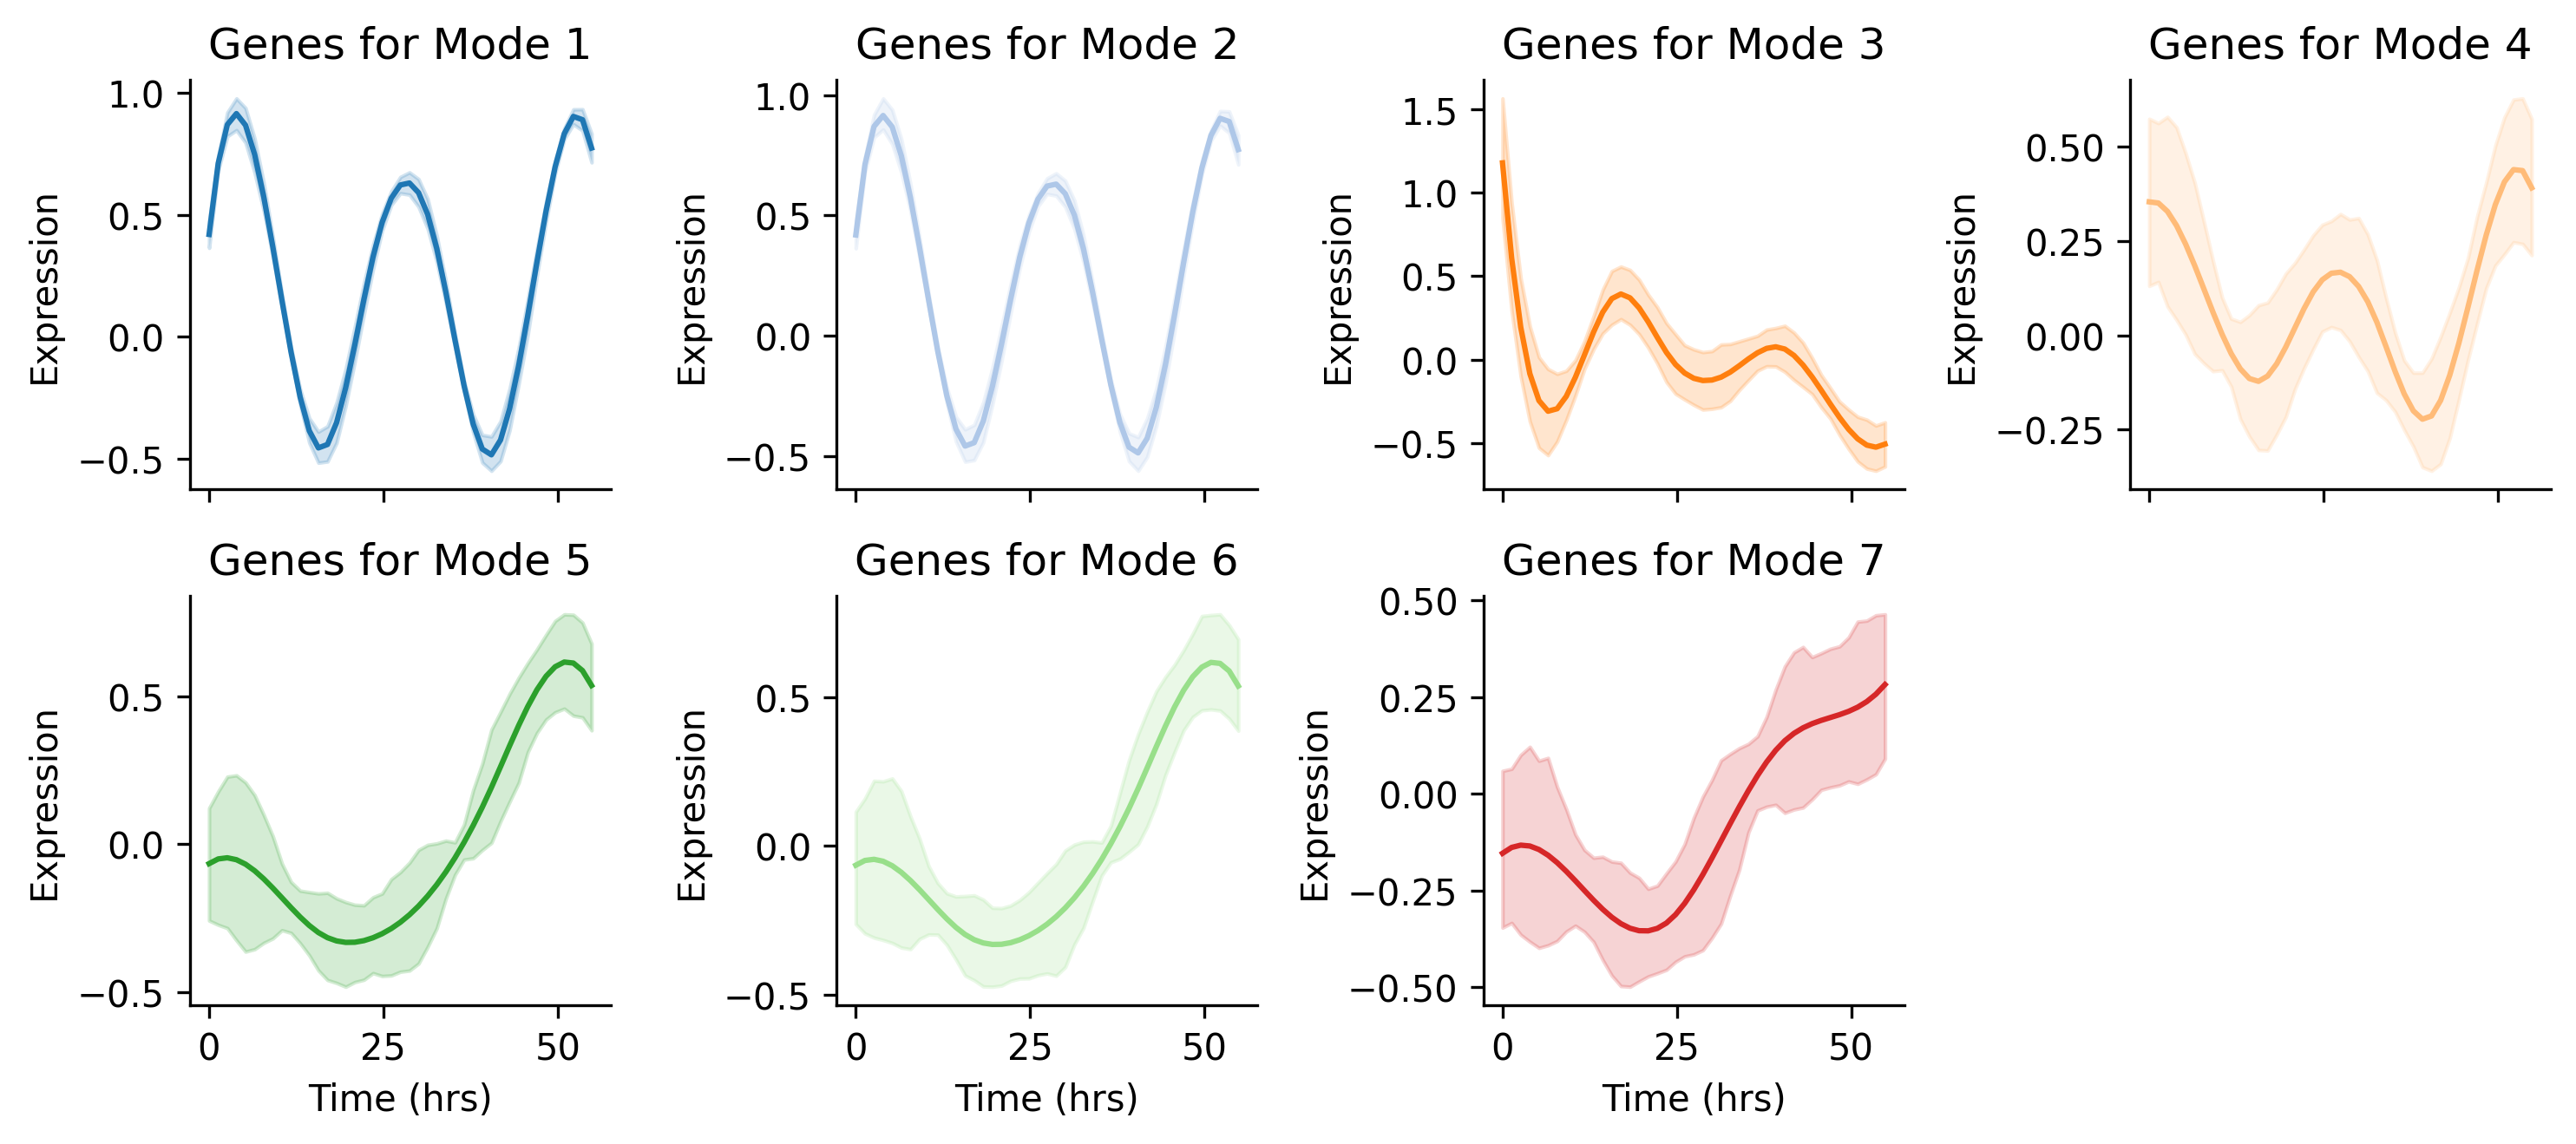

In [10]:
top_n = 50

# get the normalized expression data
pdf = d.copy()
pdf = pdf.reset_index(drop=False)
pdf = nb.meltDf(pdf)
pdf = pdf[pdf['control'] != 'control']

# get the top genes for each mode
phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=high_exp_genes)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)

def smooth_rows(df, n_points=100, power=3, standardize=True):
    """A function to smooth the rows of a dataframe

    args:
        : df (dataframe): m observations by n timepoints
        : n_points (int): number of points to interpolate over
        : power (int): power of the spline
    """

    S = np.zeros((df.shape[0], n_points))

    for i, (idx, row) in enumerate(df.iterrows()):
        
        y = row.values  
        x = list(range(len(y)))
        x_hat = np.linspace(0, len(y), n_points) 

        spl = make_interp_spline(x, y, k=power)  
        smooth_row = spl(x_hat)
        if standardize:
            smooth_row =  (smooth_row - smooth_row.mean())/(smooth_row.std())
        S[i, :] = smooth_row
    
    S = pd.DataFrame(S, index=df.index, columns=x_hat)
    return S

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 4.5

fig, axs = plt.subplots(2, 4, sharex=True)
axs = axs.ravel()

cmap = matplotlib.cm.get_cmap('tab20', 20)
colors = cmap.colors

for i, _mode in enumerate(phi.columns):

    # get top genes for each mode
    top_genes = phi[phi[_mode] <= top_n][_mode].index.to_list()

    # get the normalized expression of those genes
    tmp = pdf[pdf['geneName'].isin(top_genes)]
    tmp = pd.pivot_table(tmp, 
                     index='geneName', 
                     columns='hours',
                     values='value',
                     aggfunc='mean')

    smooth = smooth_rows(tmp, n_points=50, power=3)
    smooth = pd.melt(smooth)
    smooth['hours'] = smooth['variable'] * 8
    smooth = smooth[smooth['hours'] < 56]

    sns.lineplot(data=smooth,
                 x='hours',
                 y='value',
                 ax=axs[i],
                 color=colors[i])

    axs[i].set_title(f"Genes for Mode {_mode+1}")
    axs[i].set_ylabel('Expression')
    axs[i].set_xlabel('Time (hrs)')

    
fig.delaxes(axs[7])
plt.tight_layout()
sns.despine()

# Explore the top genes for each mode

In [11]:
top_n = 200
alpha = 0.05

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=high_exp_genes)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)


# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

edf = []


for c in phi.columns:
    genes = phi[phi[c] <= top_n][c].index.to_list()
    
    enrich = gget.enrichr(genes, database=db)
    enrich = enrich[['path_name', 'adj_p_val', 'overlapping_genes']]
    enrich = enrich[enrich['adj_p_val'] <= alpha]
    enrich['mode'] = c + 1

    print(f"======== Mode {c+1} ========")
    print(enrich[['path_name']].head(10))

    edf.append(enrich)
    print()
    time.sleep(1)

    
    # break

edf = pd.concat(edf)
print('done')

Tue Jan  9 08:48:52 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


phi.shape=(8112, 7)
======== Mode 1 ========
                                           path_name
0          mitotic spindle organization (GO:0007052)
1  microtubule cytoskeleton organization involved...
2  mitotic sister chromatid segregation (GO:0000070)
3               chromosome condensation (GO:0030261)
4          sister chromatid segregation (GO:0000819)
5              mitotic nuclear division (GO:0140014)
6                    chromatin assembly (GO:0031497)
7                            DNA repair (GO:0006281)
8               nucleosome organization (GO:0034728)
9  regulation of mitotic cell cycle phase transit...



Tue Jan  9 08:48:53 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 2 ========
                                           path_name
0          mitotic spindle organization (GO:0007052)
1  microtubule cytoskeleton organization involved...
2  mitotic sister chromatid segregation (GO:0000070)
3               chromosome condensation (GO:0030261)
4          sister chromatid segregation (GO:0000819)
5              mitotic nuclear division (GO:0140014)
6                    chromatin assembly (GO:0031497)
7                            DNA repair (GO:0006281)
8               nucleosome organization (GO:0034728)
9  regulation of mitotic cell cycle phase transit...



Tue Jan  9 08:48:54 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 3 ========
Empty DataFrame
Columns: [path_name]
Index: []



Tue Jan  9 08:48:56 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 4 ========
Empty DataFrame
Columns: [path_name]
Index: []



Tue Jan  9 08:48:57 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 5 ========
                                           path_name
0  cellular response to type I interferon (GO:007...
1   type I interferon signaling pathway (GO:0060337)
2   cytokine-mediated signaling pathway (GO:0019221)
3                    chromatin assembly (GO:0031497)
4  negative regulation of transcription, DNA-temp...
5               nucleosome organization (GO:0034728)
6  negative regulation of transcription by RNA po...
7  cellular response to cytokine stimulus (GO:007...
8  cellular response to interferon-gamma (GO:0071...
9  vascular associated smooth muscle cell develop...



Tue Jan  9 08:48:58 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 6 ========
                                           path_name
0  cellular response to type I interferon (GO:007...
1   type I interferon signaling pathway (GO:0060337)
2   cytokine-mediated signaling pathway (GO:0019221)
3                    chromatin assembly (GO:0031497)
4  negative regulation of transcription, DNA-temp...
5               nucleosome organization (GO:0034728)
6  negative regulation of transcription by RNA po...
7  cellular response to cytokine stimulus (GO:007...
8  cellular response to interferon-gamma (GO:0071...
9  vascular associated smooth muscle cell develop...



Tue Jan  9 08:49:00 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


======== Mode 7 ========
                                           path_name
0  cellular response to epidermal growth factor s...
1              regulation of cell cycle (GO:0051726)
2  mitotic sister chromatid segregation (GO:0000070)
3      regulation of mitotic cell cycle (GO:0007346)
4  regulation of attachment of spindle microtubul...
5  regulation of cyclin-dependent protein serine/...
6  regulation of cyclin-dependent protein kinase ...

done


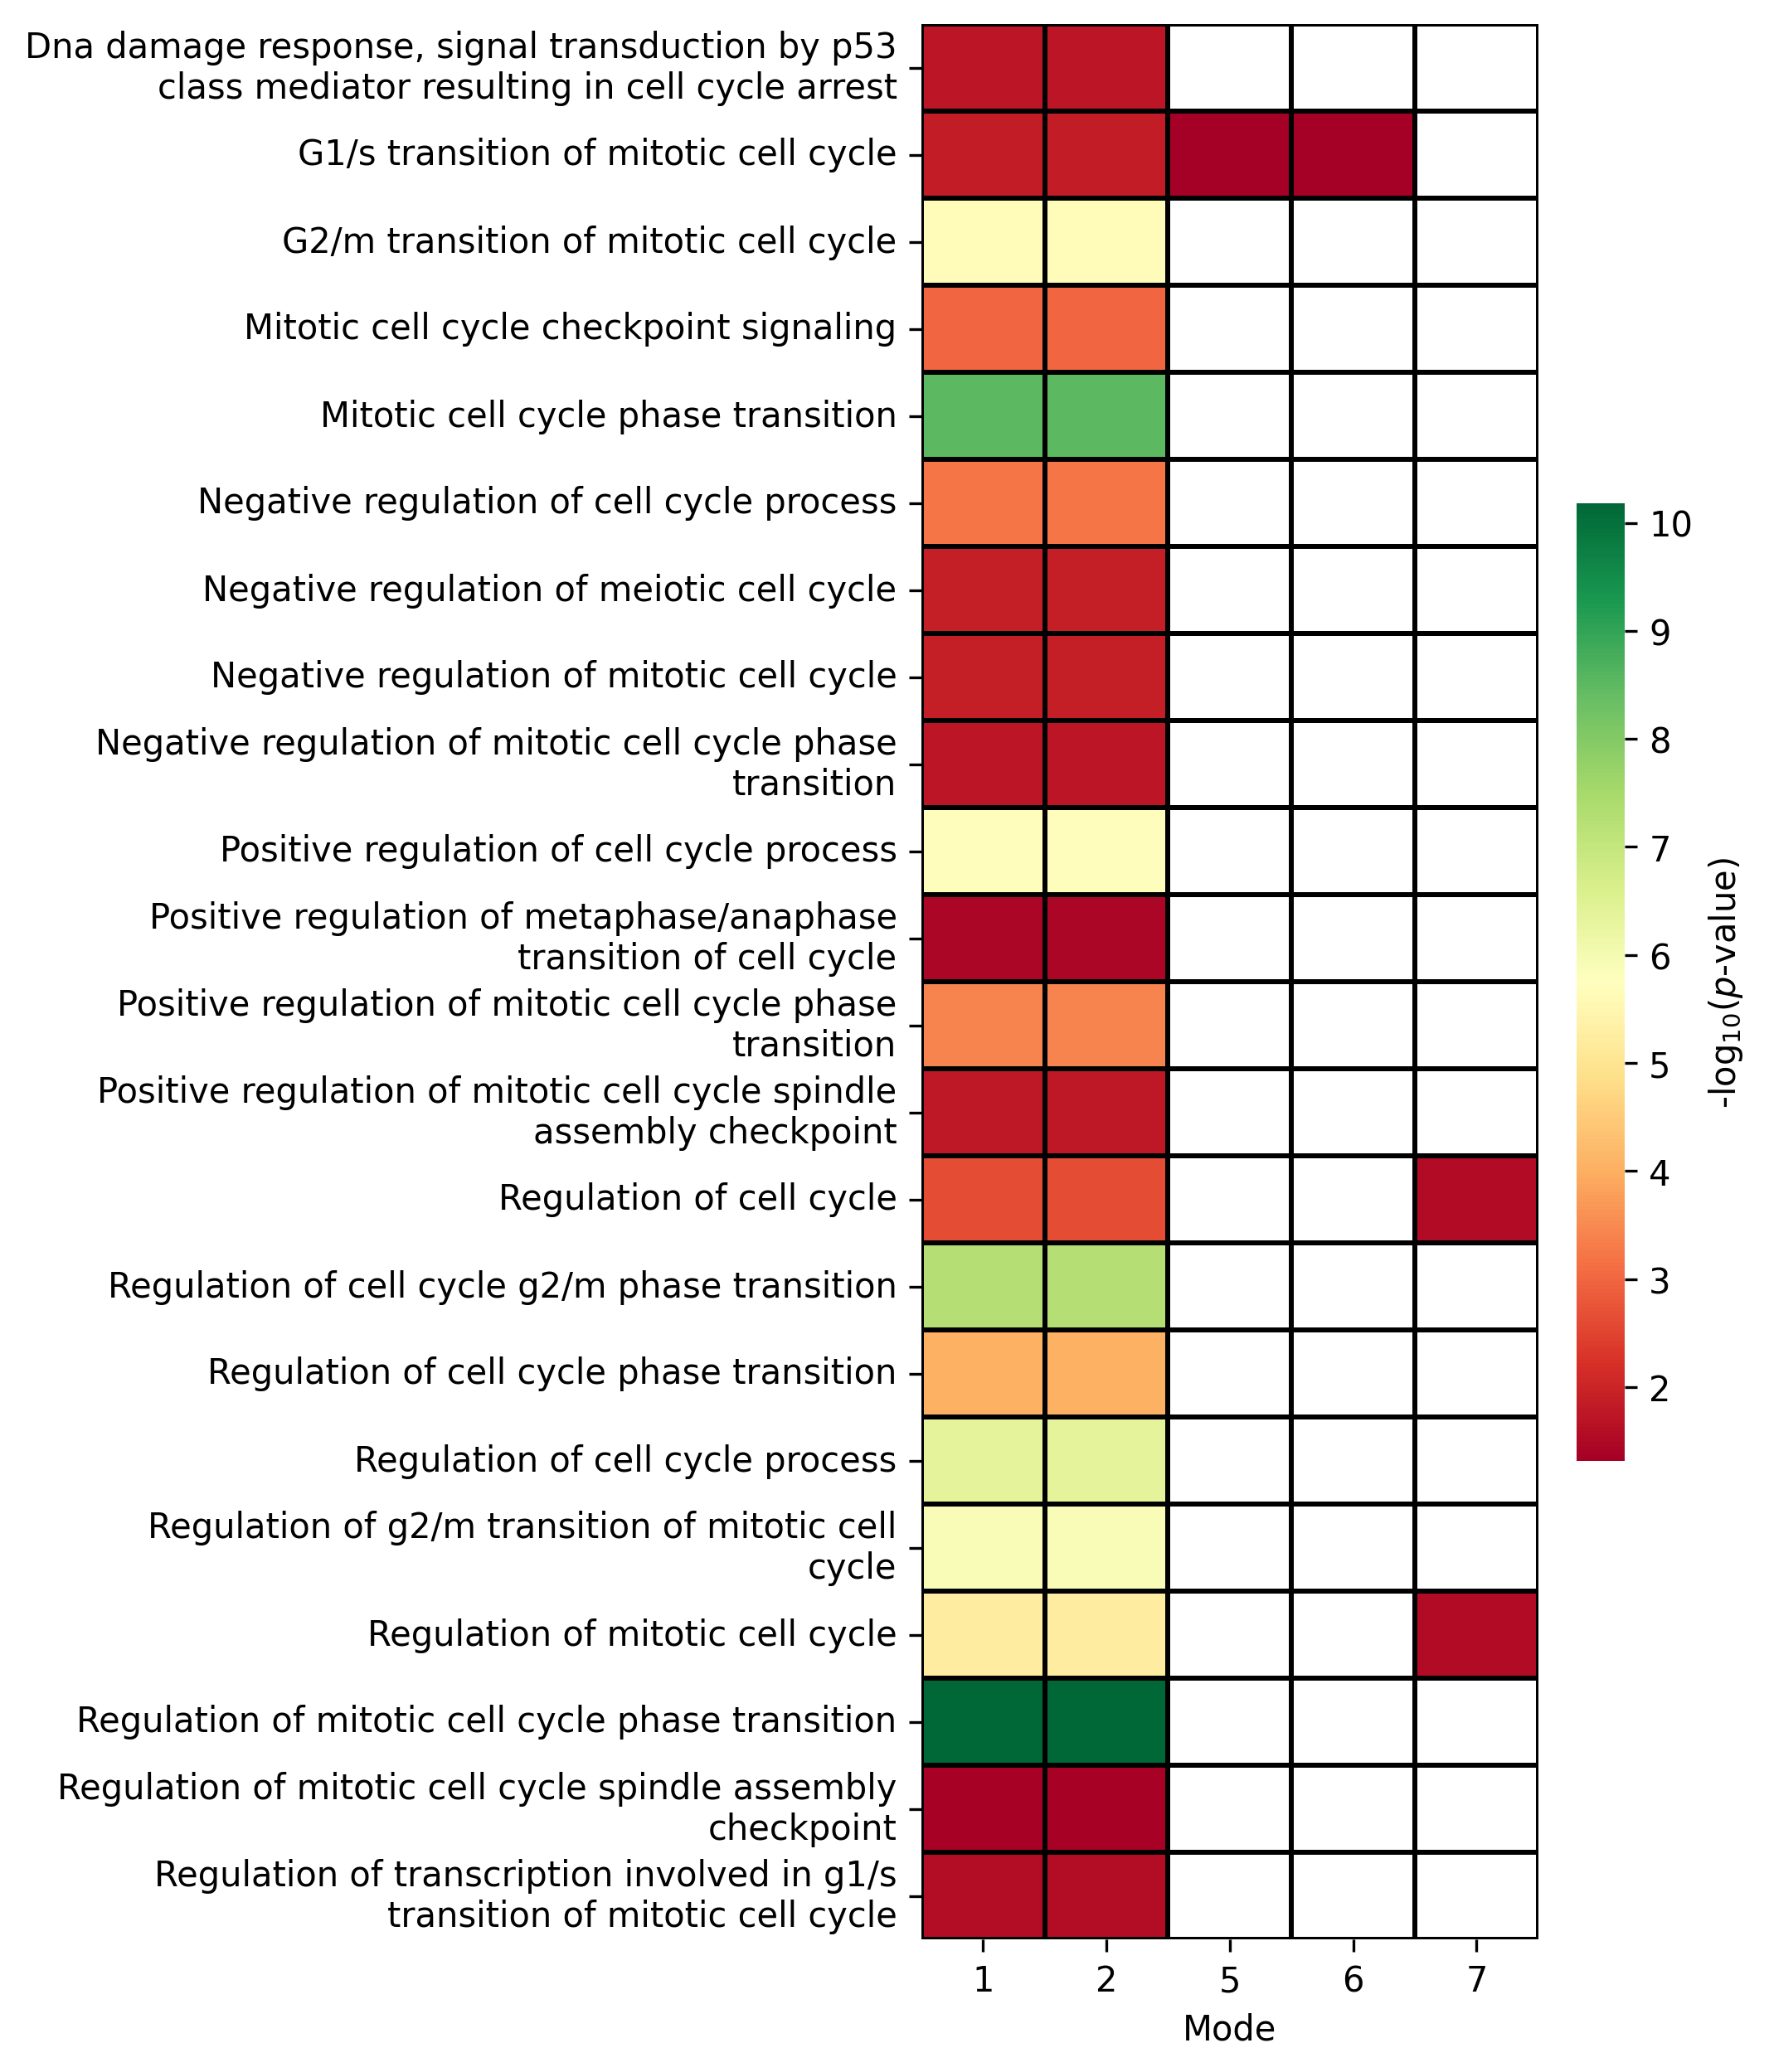

In [12]:
alpha = 0.05

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 10

pdf = pd.pivot_table(pdf, 
                     index='name',
                     columns='mode',
                     values='logp')

sns.heatmap(pdf,
            cmap='RdYlGn',
            lw=1,
            linecolor='k',
            cbar_kws={'label' : r"-log$_{10}$($p$-value)",
                      'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("Mode")
wrap_ylabels(plt.gca(), width=50)


# sns.heatmap(pdf[mode_columns].head(n_plot),
#             lw=1,
#             linecolor='k',
#             annot=True,
#             cbar=False,
#             cmap='viridis')

# plt.ylabel("")
# plt.xlabel("Mode")

In [13]:
# break

# Obersevability Based on Hasnain Method

In [14]:
# A = dmd_res['Atilde']
# u = dmd_res['u_r']
# x0_embedded = dmd_res['data_embedded'][:,0,:]

# print(f"{A.shape=} {x0_embedded.shape=} {u.shape=}")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 6

# fig, axs = plt.subplots(3, 3)
# axs = axs.ravel()

# for i, nT in enumerate(np.arange(1, 82, 9)):
    
    
#     _, Gtemp = hasnain_DMD.gram_matrix(A, 
#                                        x0_embedded, 
#                                        nT=nT, 
#                                        reduced=True, 
#                                        projection_matrix=u)

#     axs[i].imshow(np.log1p(np.abs(Gtemp)))
#     axs[i].set_yticks([])
#     axs[i].set_xticks([])
#     axs[i].set_title(nT)

# plt.tight_layout()

In [15]:
A = dmd_res['Atilde']
u = dmd_res['u_r']
x0_embedded = dmd_res['data_embedded'][:,0,:]

print(f"{A.shape=} {x0_embedded.shape=}  {u.shape=}")
nT = 10
_, G = hasnain_DMD.gram_matrix(A, 
                            x0_embedded, 
                            nT=nT, 
                            reduced=True, 
                            projection_matrix=u)
print(f"{G.shape=}")

A.shape=(7, 7) x0_embedded.shape=(7, 2)  u.shape=(8112, 7)
G.shape=(8112, 8112)


D.shape=(8112,) V.shape=(8112, 8112)
evals.max()=363727.6569 evals.min()=-0.0000


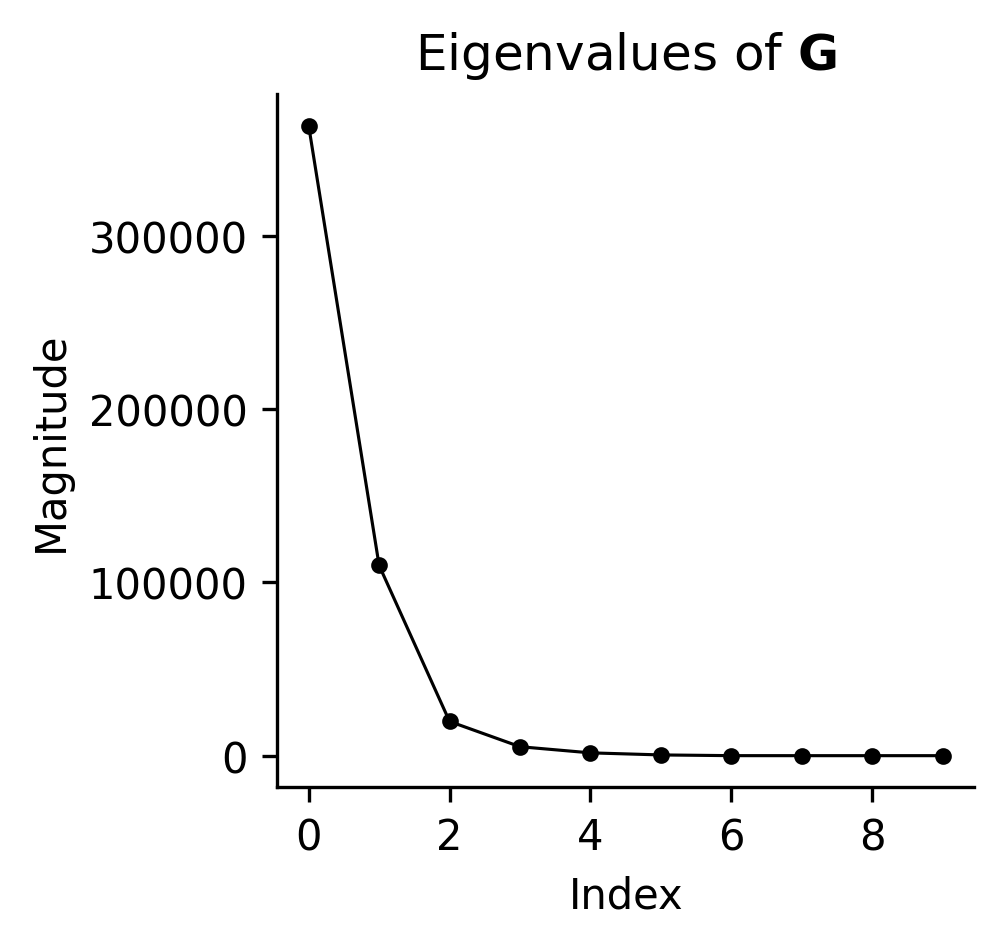

In [16]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(G)
print(f"{D.shape=}{ V.shape=}")

n_val = 10
evals = np.real(D[:n_val])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
plt.title(r"Eigenvalues of $\mathbf{G}$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

evals.max()=363727.6569 evals.min()=-0.0000


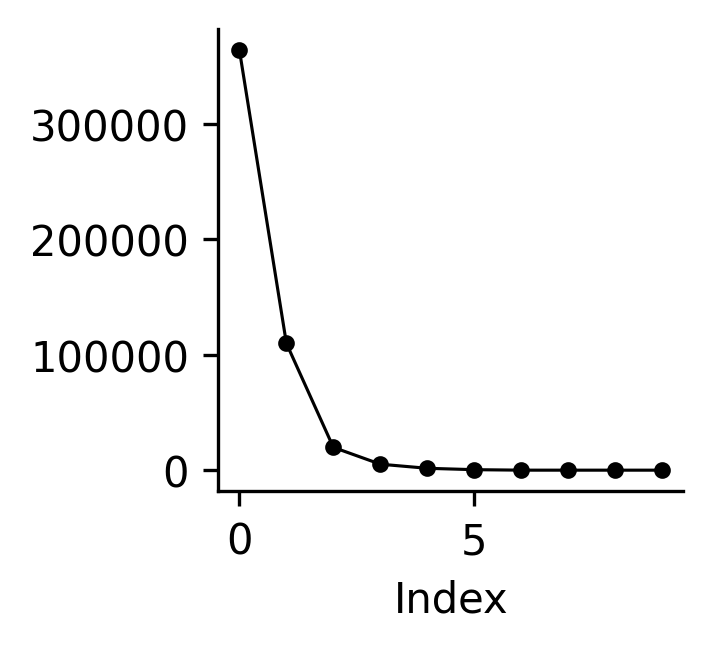

In [17]:
n_val = 10
evals = np.real(D[:n_val])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
# plt.title(r"Eigenvalues of $\mathbf{G}$")
# plt.ylabel(r"Magnitude")
# plt.yscale("log")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

In [18]:
# break

In [19]:
obs = pd.DataFrame({'gene' : high_exp_genes,
                    'ev1' : V[:,0],
                    'weight' : np.abs(np.real(V[:,0])),
                    'weight_rel' : np.real(V[:,0])}  )

obs['rank'] = obs['weight'].rank(ascending=False)
obs = obs.sort_values(by='rank', ascending=True)

obs.head(10)

,gene,ev1,weight,weight_rel,rank
7298,UBE2C,0.267925+0.000000j,0.267925,0.267925,1.0
7021,TOP2A,0.232871+0.000000j,0.232871,0.232871,2.0
1096,CDCA3,0.201745+0.000000j,0.201745,0.201745,3.0
3352,KIF20A,0.188917+0.000000j,0.188917,0.188917,4.0
4967,PLK1,0.181114+0.000000j,0.181114,0.181114,5.0
1104,CDK1,0.149775+0.000000j,0.149775,0.149775,6.0
463,ASPM,0.122540+0.000000j,0.122540,0.122540,7.0
3414,KPNA2,0.122189+0.000000j,0.122189,0.122189,8.0
568,AURKB,0.122163+0.000000j,0.122163,0.122163,9.0
2911,HJURP,0.111110+0.000000j,0.111110,0.111110,10.0


In [20]:
obs.sort_values(by='weight_rel', ascending=True).head()
print(obs['weight_rel'].min())
print(obs['weight_rel'].max())

-0.025415847756961072
0.2679248973946904


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


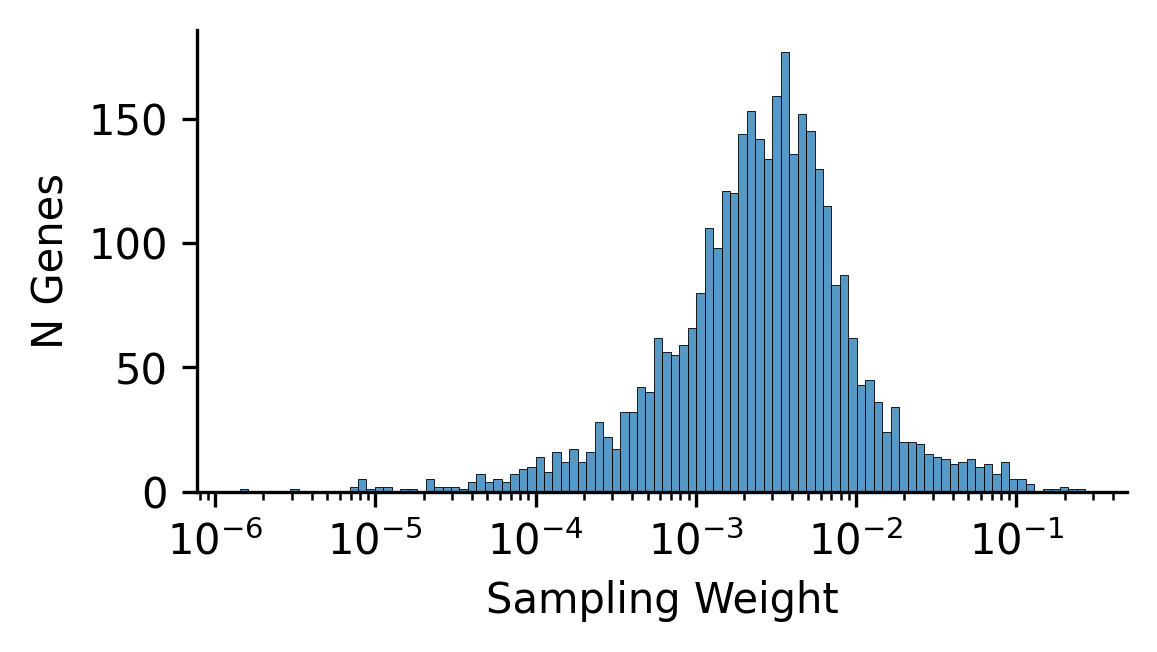

In [21]:
pdf = obs.copy()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.histplot(data=pdf, 
             x='weight_rel', 
             bins=100,
             log_scale=True,)

plt.ylabel('N Genes')
plt.xlabel('Sampling Weight')
sns.despine()

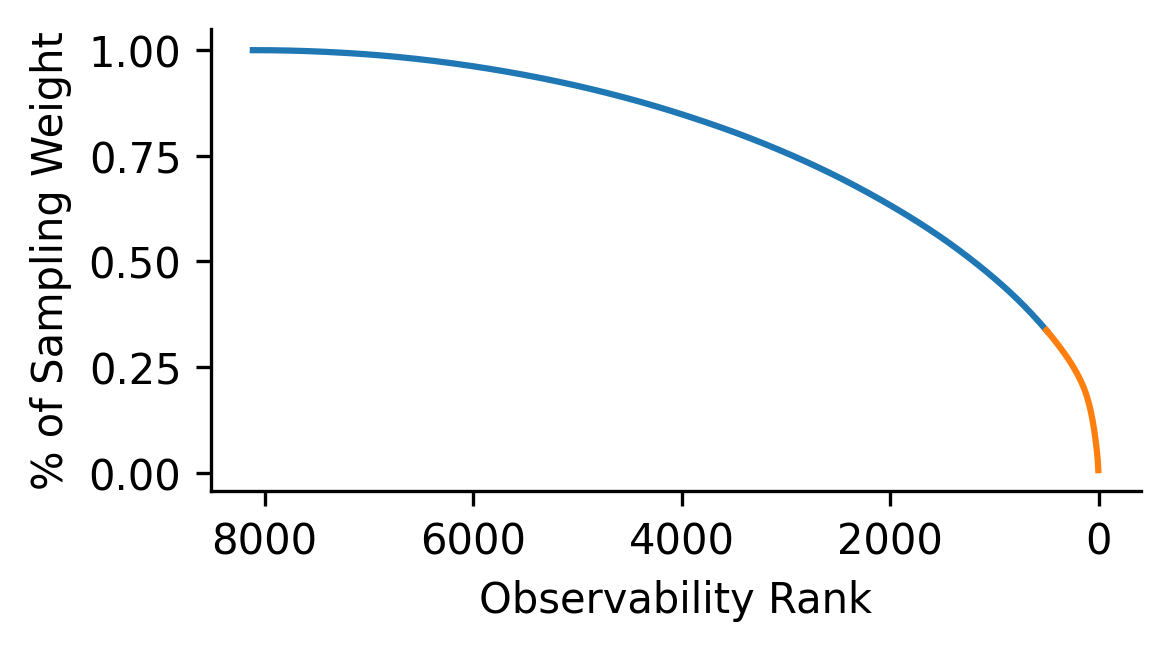

In [22]:
n = 500
pdf = obs.copy()
pdf['cat'] = np.where(pdf['rank'] < n, 1, 0)
pdf['weight_scaled'] = pdf['weight'] - pdf['weight'].min()
pdf['cumsum'] = pdf['weight_scaled'].cumsum() / pdf['weight_scaled'].sum()
pdf['obs_rank'] = pdf['rank'] + 1

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.lineplot(data=pdf, 
             x='obs_rank',
             y='cumsum',
             hue='cat')

sns.despine()
plt.ylabel("% of Sampling Weight")
plt.xlabel("Observability Rank")
plt.gca().legend().remove()
# plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.yscale('log')
# plt.xscale('log')

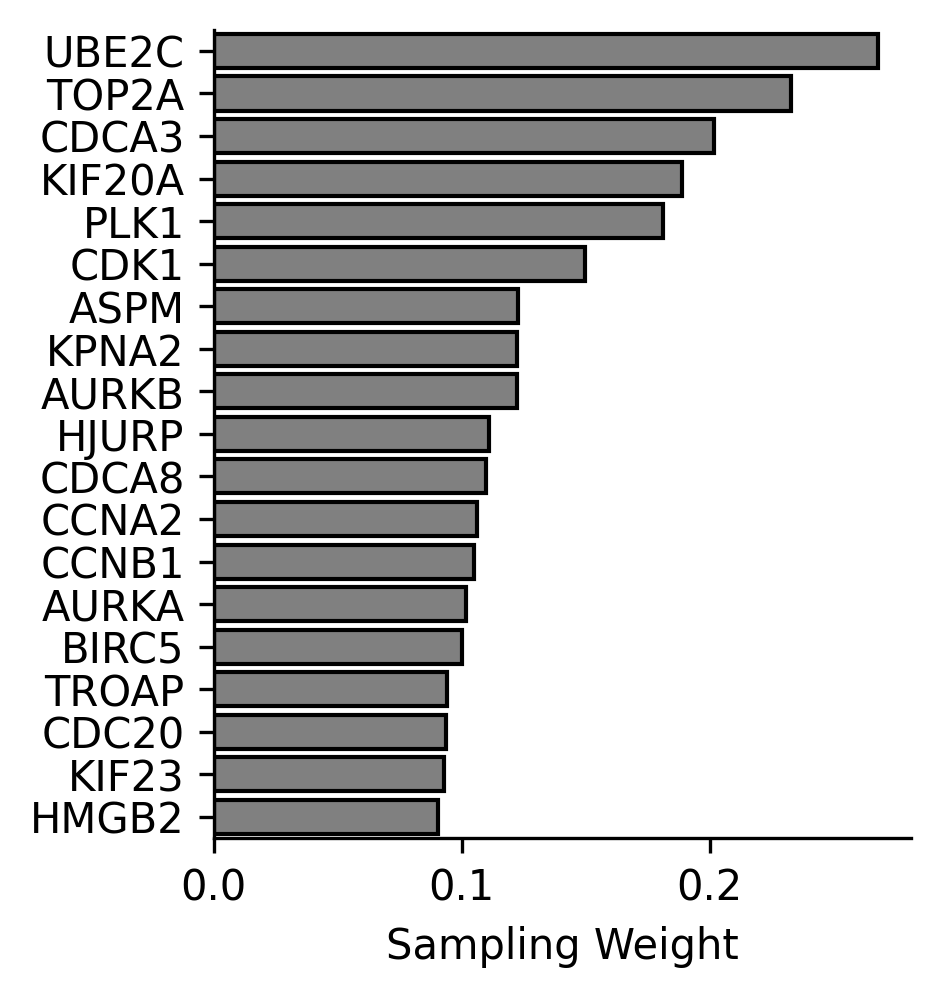

In [23]:
top = 20

pdf = obs.copy()
pdf = pdf[pdf['rank'] < top]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

sns.barplot(data=pdf,
            y='gene',
            x='weight',
            color='grey',
            ec='k')

plt.ylabel("")
plt.xlabel("Sampling Weight")
sns.despine()

In [24]:
top = 100
pdf = obs.copy()

# db = 'ontology'
# db = 'WikiPathway_2021_Human'
db = 'KEGG_2021_Human'

edf = gget.enrichr(pdf['gene'].head(top), database=db)
edf.head(10)

Tue Jan  9 08:53:05 2024 INFO Performing Enichr analysis using database KEGG_2021_Human.


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Cell cycle,1.648198e-15,29.287526,996.920862,"[CDKN2D, PLK1, BUB1B, TTK, CCNA2, CDC20, CCNB2...",9.889187e-14,KEGG_2021_Human
1,2,Oocyte meiosis,2.000183e-12,23.057110,621.107404,"[CDC20, CCNB2, CCNB1, ESPL1, PTTG1, PTTG2, PLK...",6.000548e-11,KEGG_2021_Human
2,3,Progesterone-mediated oocyte maturation,1.767874e-09,21.528922,433.882861,"[CCNA2, CCNB2, CCNB1, PLK1, CDK1, KIF22, BUB1,...",3.535749e-08,KEGG_2021_Human
3,4,Alcoholism,4.317859e-06,9.634587,119.013655,"[H2BC12, H2AX, H3C8, H2BC7, H2AC20, GNB3, H3C3...",6.222970e-05,KEGG_2021_Human
4,5,Systemic lupus erythematosus,5.185808e-06,11.626680,141.491870,"[H2BC12, H2AX, H3C8, H2BC7, H2AC20, H3C3, H3C2]",6.222970e-05,KEGG_2021_Human
5,6,Human T-cell leukemia virus 1 infection,1.426279e-05,8.114156,90.536590,"[CCNA2, CDC20, CCNB2, ESPL1, PTTG1, PTTG2, BUB...",1.426279e-04,KEGG_2021_Human
6,7,Neutrophil extracellular trap formation,4.595112e-05,8.154673,81.448325,"[H2BC12, H2AX, H3C8, H2BC7, H2AC20, H3C3, H3C2]",3.938667e-04,KEGG_2021_Human
7,8,p53 signaling pathway,4.915839e-04,11.975242,91.225929,"[CCNB2, CCNB1, CDK1, GTSE1]",3.407545e-03,KEGG_2021_Human
8,9,FoxO signaling pathway,5.111318e-04,8.259816,62.600182,"[PLK4, CDKN2D, CCNB2, CCNB1, PLK1]",3.407545e-03,KEGG_2021_Human
9,10,Cellular senescence,1.123634e-03,6.883583,46.747699,"[CCNA2, CCNB2, CCNB1, CDK1, FOXM1]",6.741807e-03,KEGG_2021_Human


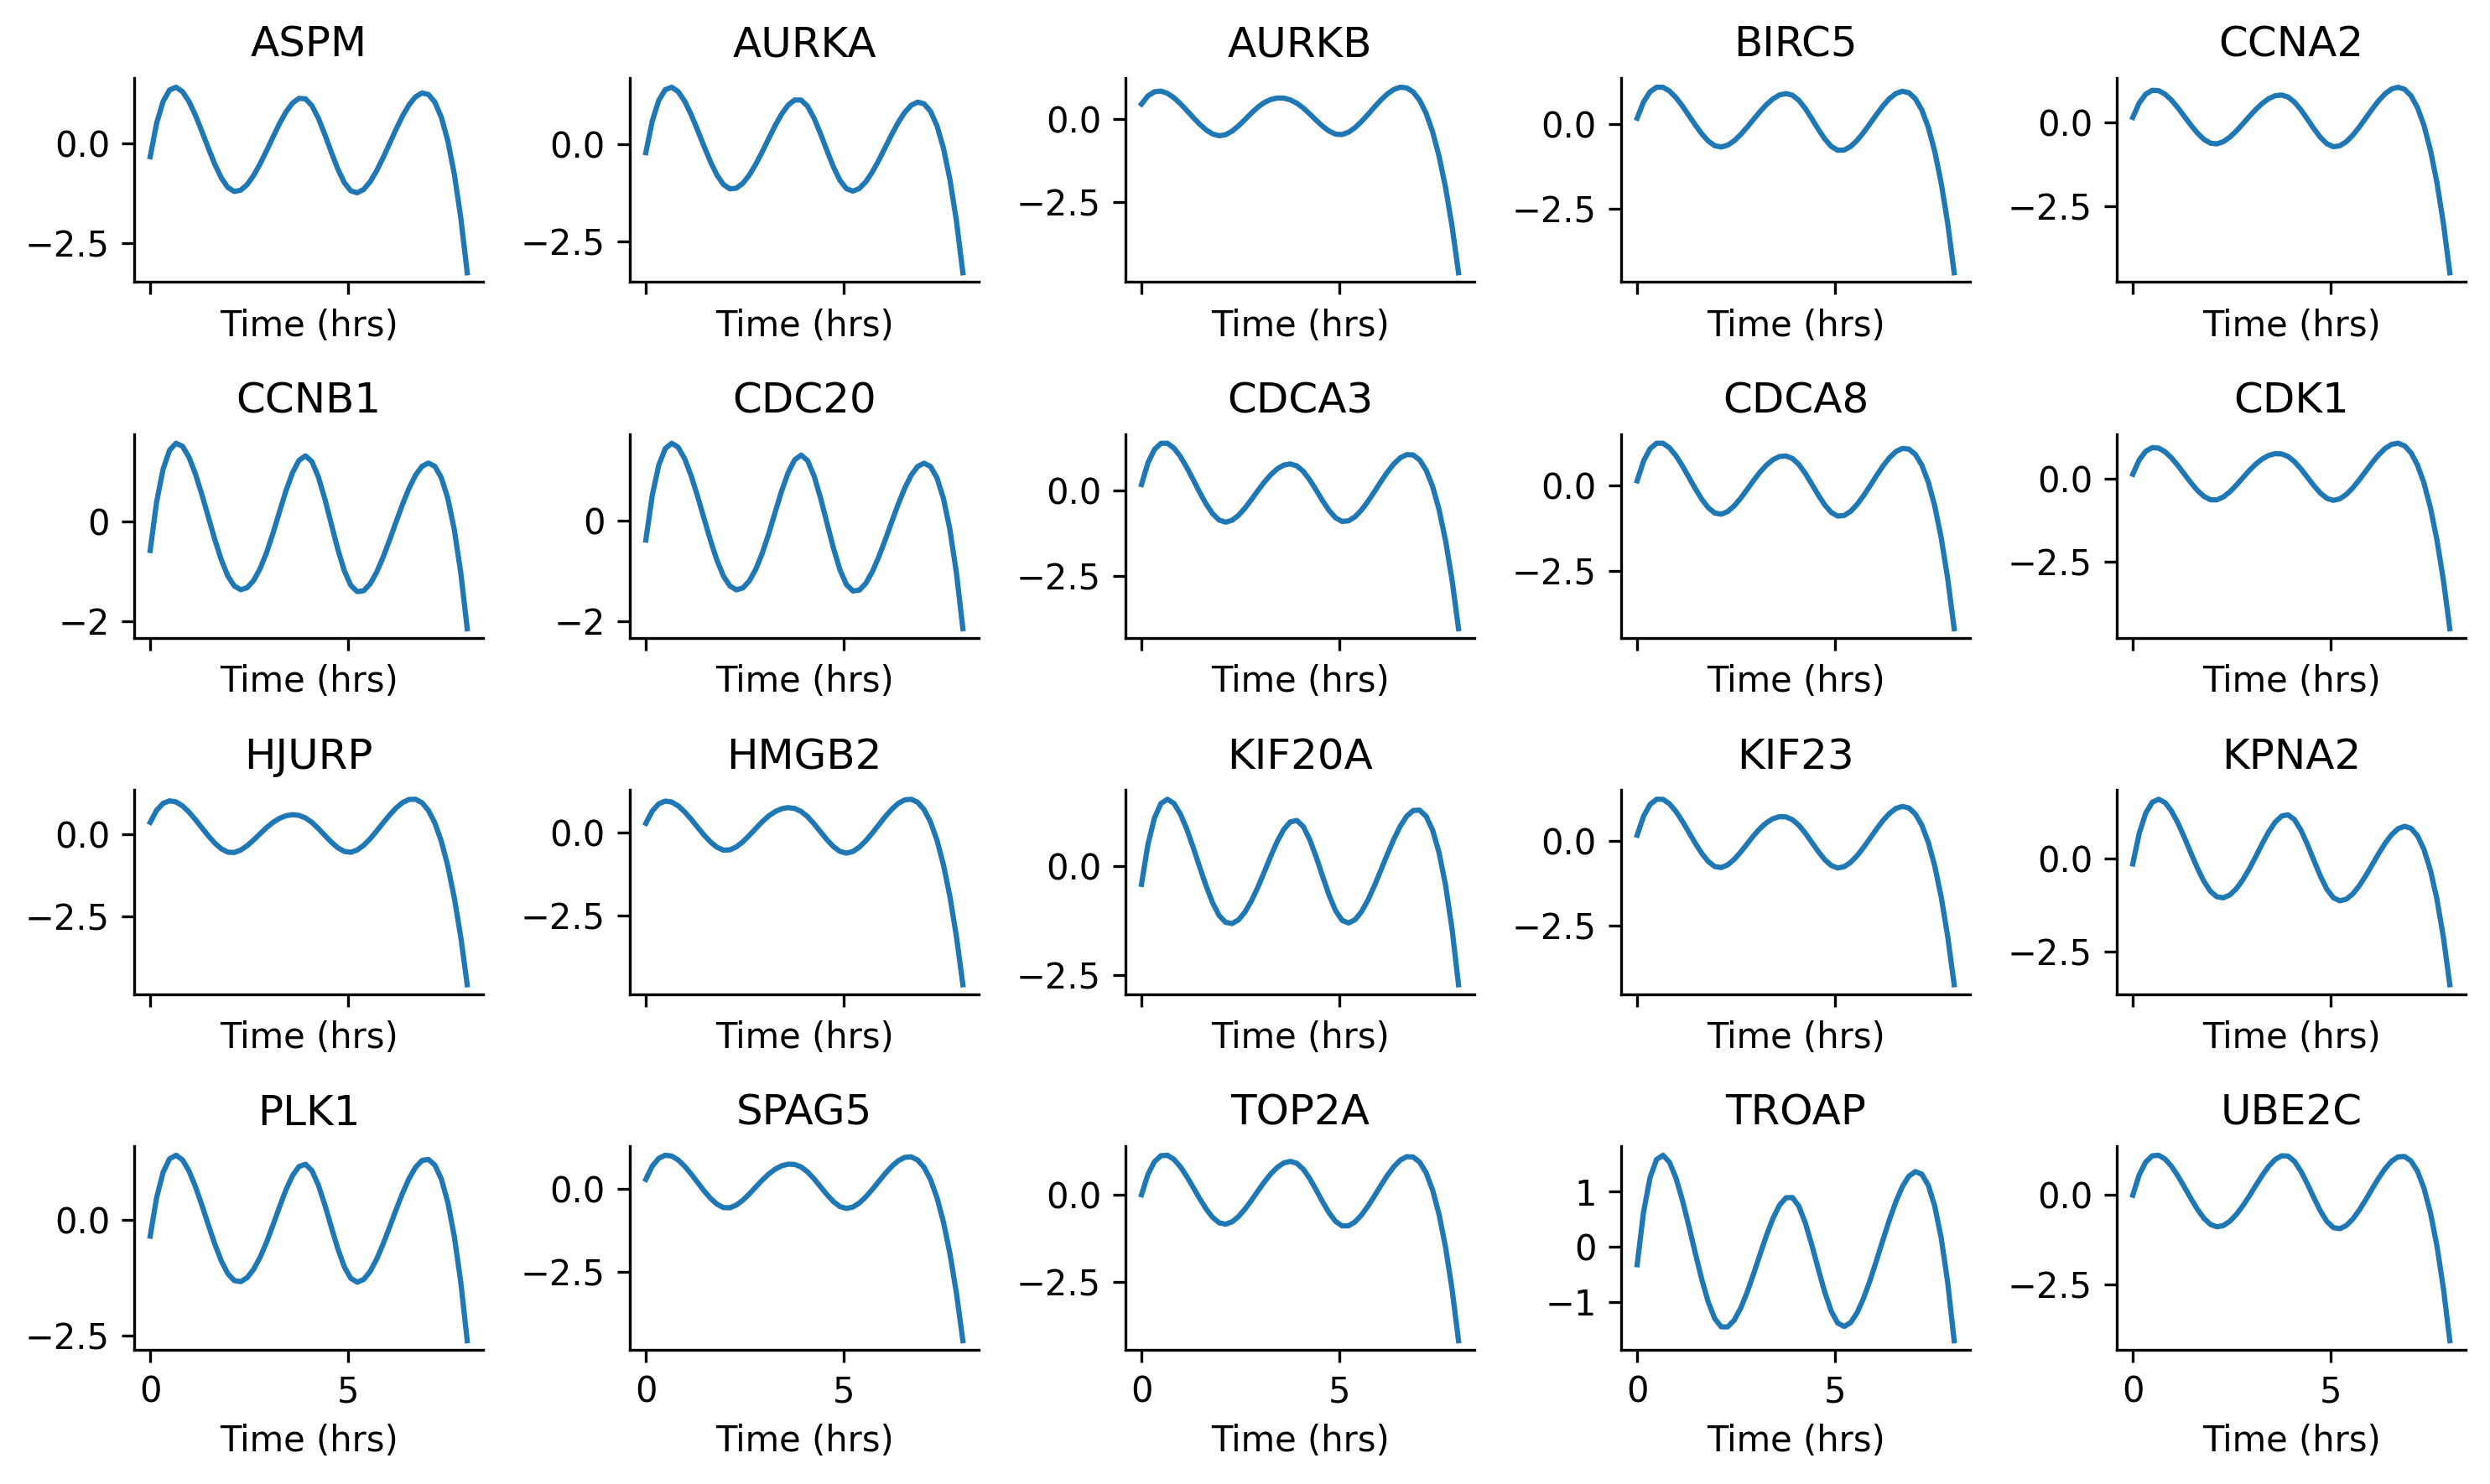

In [25]:
top = 20
top_genes = obs[obs['rank'] < top+1]['gene'].to_list()


# get the normalized expression data
pdf = d.copy()
pdf = pdf.reset_index(drop=False)
pdf = nb.meltDf(pdf)
pdf = pdf[pdf['control'] != 'control']
pdf = pdf[pdf['geneName'].isin(top_genes)]


pdf = pd.pivot_table(pdf, 
                 index='geneName', 
                 columns='hours',
                 values='value',
                 aggfunc='mean')


smooth = smooth_rows(pdf, n_points=50, power=3)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 6
fig, axs = plt.subplots(4, 5, sharex=True)
axs = axs.ravel()

for i, (idx, row) in enumerate(smooth.iterrows()):
    axs[i].plot(smooth.columns.to_list(),
                row.to_list(),)
    axs[i].set_title(idx)
    axs[i].set_ylabel("")
    # axs[i].set_yticks([])
    axs[i].set_xlabel("Time (hrs)")
    

sns.despine()
plt.tight_layout()


In [26]:
top = 20
top_genes = obs[obs['rank'] < top+1]['gene'].to_list() 

gene_table = pd.read_csv(gene_path)
gene_table = gene_table[gene_table['Feature'] == 'gene']
gene_table = gene_table[gene_table['gene_name'].isin(top_genes)]
print(f"{gene_table.shape=}")

info_table = gget.info(gene_table['gene_id'].to_list())
print(f"{info_table.shape=}")
info_table.columns

/home/cstansbu/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


gene_table.shape=(20, 26)
info_table.shape=(20, 34)


Index(['ensembl_id', 'uniprot_id', 'pdb_id', 'ncbi_gene_id', 'species',
       'assembly_name', 'primary_gene_name', 'ensembl_gene_name', 'synonyms',
       'parent_gene', 'protein_names', 'ensembl_description',
       'uniprot_description', 'ncbi_description', 'subcellular_localisation',
       'object_type', 'biotype', 'canonical_transcript', 'seq_region_name',
       'strand', 'start', 'end', 'all_transcripts', 'transcript_biotypes',
       'transcript_names', 'transcript_strands', 'transcript_starts',
       'transcript_ends', 'all_exons', 'exon_starts', 'exon_ends',
       'all_translations', 'translation_starts', 'translation_ends'],
      dtype='object')

In [27]:
for idx, row in info_table.iterrows():
    print(f"==== {row['primary_gene_name']} ====")
    print(row['ncbi_description'])
    print()

==== CDCA8 ====
This gene encodes a component of the chromosomal passenger complex. This complex is an essential regulator of mitosis and cell division. This protein is cell-cycle regulated and is required for chromatin-induced microtubule stabilization and spindle formation. Alternate splicing results in multiple transcript variants. Pseudgenes of this gene are found on chromosomes 7, 8 and 16. [provided by RefSeq, Apr 2013]

==== CDC20 ====
CDC20 appears to act as a regulatory protein interacting with several other proteins at multiple points in the cell cycle.  It is required for two microtubule-dependent processes, nuclear movement prior to anaphase and chromosome separation. [provided by RefSeq, Jul 2008]

==== ASPM ====
This gene is the human ortholog of the Drosophila melanogaster 'abnormal spindle' gene (asp), which is essential for normal mitotic spindle function in embryonic neuroblasts. Studies in mouse also suggest a role of this gene in mitotic spindle regulation, with a p

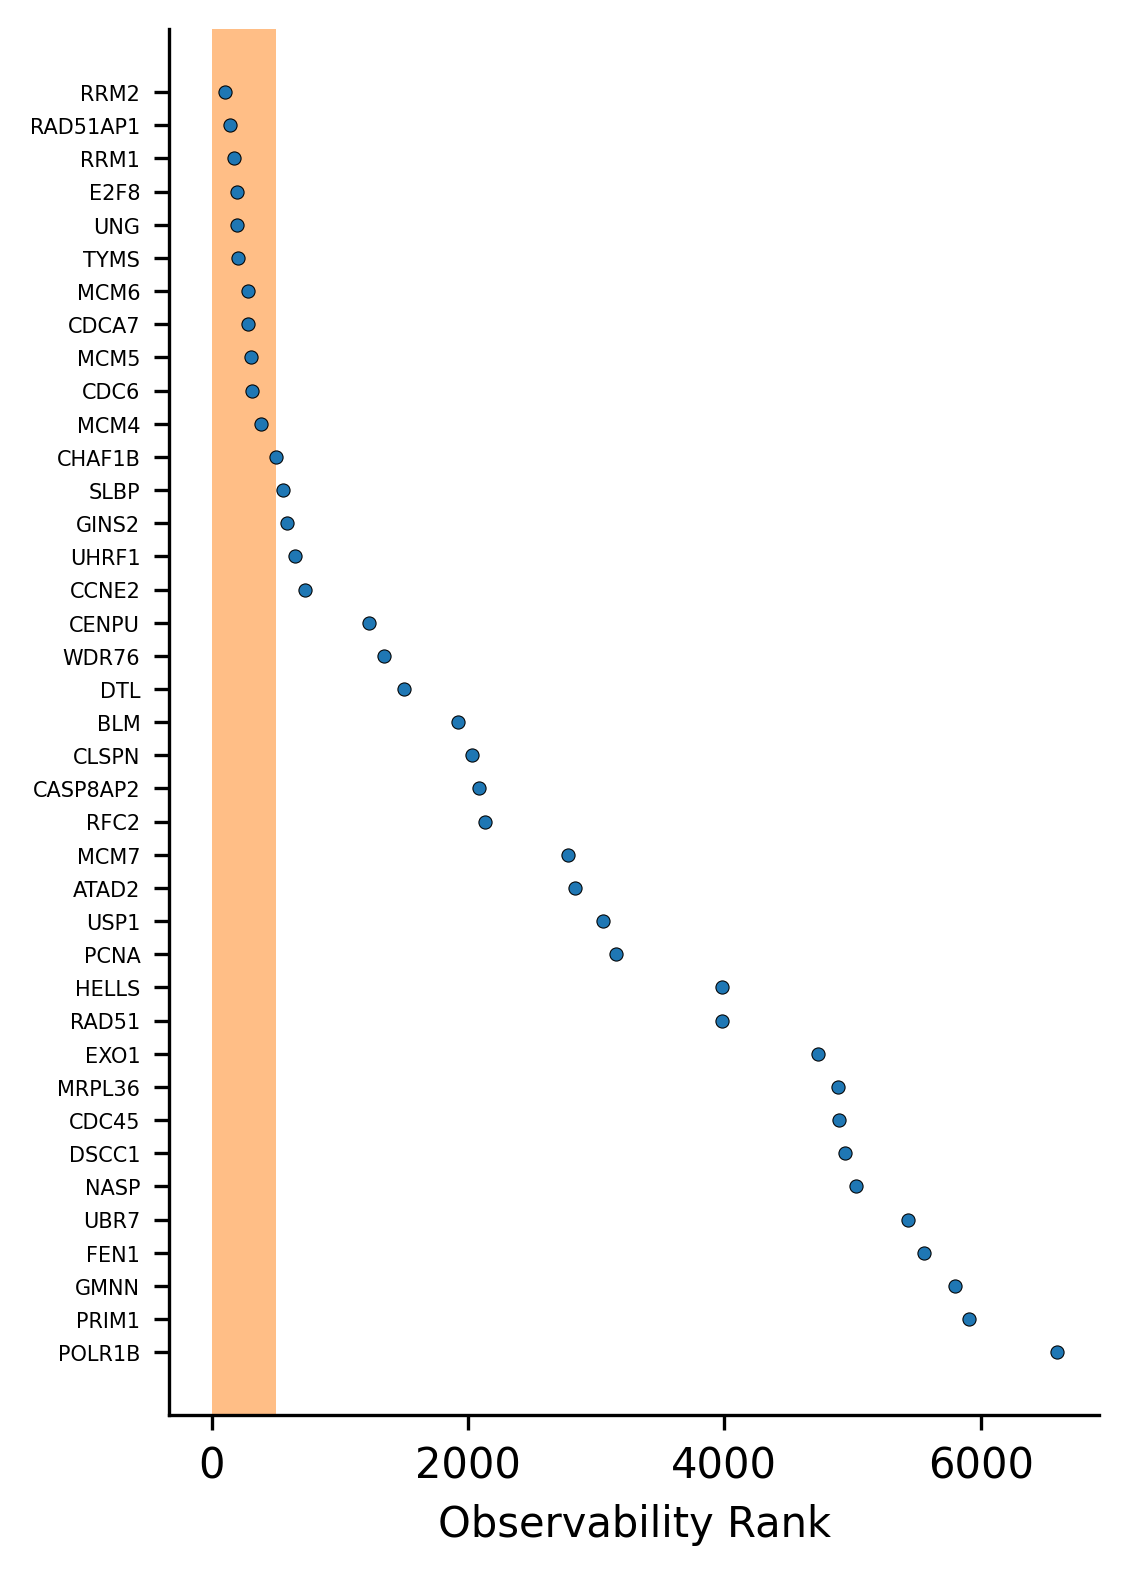

In [28]:
cell_cycle = nb.s_genes 
# cell_cycle = nb.g2_genes 

pdf = obs.copy()
pdf = pdf[pdf['gene'].isin(cell_cycle)]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 6

sns.scatterplot(data=pdf, 
                y='gene',
                x='rank',
                s=10,
                ec='k',
                zorder=3
               )

plt.axvspan(0, 500, 
            zorder=1, 
            color='C1',
            ec='none',
            alpha=0.5)

plt.ylabel("")
plt.xlabel("Observability Rank")
plt.gca().tick_params(axis='y', labelsize=5)
sns.despine()

In [29]:
n_gene = 100
# genes = obs['gene'].head(n_gene).to_list()
genes = obs['gene'].head(n_gene).to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

edf = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(20))



Tue Jan  9 08:55:16 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


                                                                    path_name  \
0      microtubule cytoskeleton organization involved in mitosis (GO:1902850)   
1                           mitotic sister chromatid segregation (GO:0000070)   
2                                   mitotic spindle organization (GO:0007052)   
3                                       mitotic nuclear division (GO:0140014)   
4                                   sister chromatid segregation (GO:0000819)   
5              regulation of mitotic cell cycle phase transition (GO:1901990)   
6                                            mitotic cytokinesis (GO:0000281)   
7                            mitotic metaphase plate congression (GO:0007080)   
8                             cytoskeleton-dependent cytokinesis (GO:0061640)   
9                                        chromosome condensation (GO:0030261)   
10                              regulation of cell cycle process (GO:0010564)   
11                         s

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database,n_gene,logp,name,name_sig,cell_cycle
5,1.0,regulation of mitotic cell cycle phase transition (GO:1901990),2.251582e-18,25.476327,1035.227974,"[PLK4, UBE2C, TUBB, PLK1, KIF14, BUB1B, HMMR, AURKA, CDC20, TPX2, ANLN, CENPE, CCNB1, CENPF, UBE...",2.225313e-16,GO_Biological_Process_2021,18,15.652609,Regulation of mitotic cell cycle phase transition,Regulation of mitotic cell cycle phase transition*,1
10,4.0,regulation of cell cycle process (GO:0010564),5.919049e-15,31.824373,1042.585564,"[PLK4, SPAG5, PLK1, KIF11, FBXO43, MKI67, KNSTRN, AURKB, AURKA, RACGAP1, NEK2, KIF20A, BUB1]",3.190906e-13,GO_Biological_Process_2021,13,12.496086,Regulation of cell cycle process,Regulation of cell cycle process*,1
15,1.0,mitotic cell cycle phase transition (GO:0044772),1.353629e-13,17.925409,531.144520,"[PLK4, CDKN2D, UBE2C, TUBB, PLK1, CCNF, FOXM1, AURKA, CCNA2, CCNB2, CCNB1, UBE2S, CDK1, TACC3, N...",5.016889e-12,GO_Biological_Process_2021,15,11.299566,Mitotic cell cycle phase transition,Mitotic cell cycle phase transition*,1
16,1.0,regulation of mitotic cell cycle (GO:0007346),2.650960e-13,19.590471,567.314258,"[UBE2C, PLK1, BUB1B, FBXO43, MKI67, CKS1B, CDC20, CCNB1, UBE2S, CDK1, CKS2, NEK2, DLGAP5, MAD2L1]",9.247173e-12,GO_Biological_Process_2021,14,11.033991,Regulation of mitotic cell cycle,Regulation of mitotic cell cycle*,1
18,5.0,regulation of cell cycle G2/M phase transition (GO:1902749),4.360983e-13,33.113574,942.442417,"[PLK4, TPX2, CENPF, TUBB, PLK1, KIF14, CDK1, NEK2, HMMR, GTSE1, AURKA]",1.361086e-11,GO_Biological_Process_2021,11,10.866115,Regulation of cell cycle g2/m phase transition,Regulation of cell cycle g2/m phase transition*,1


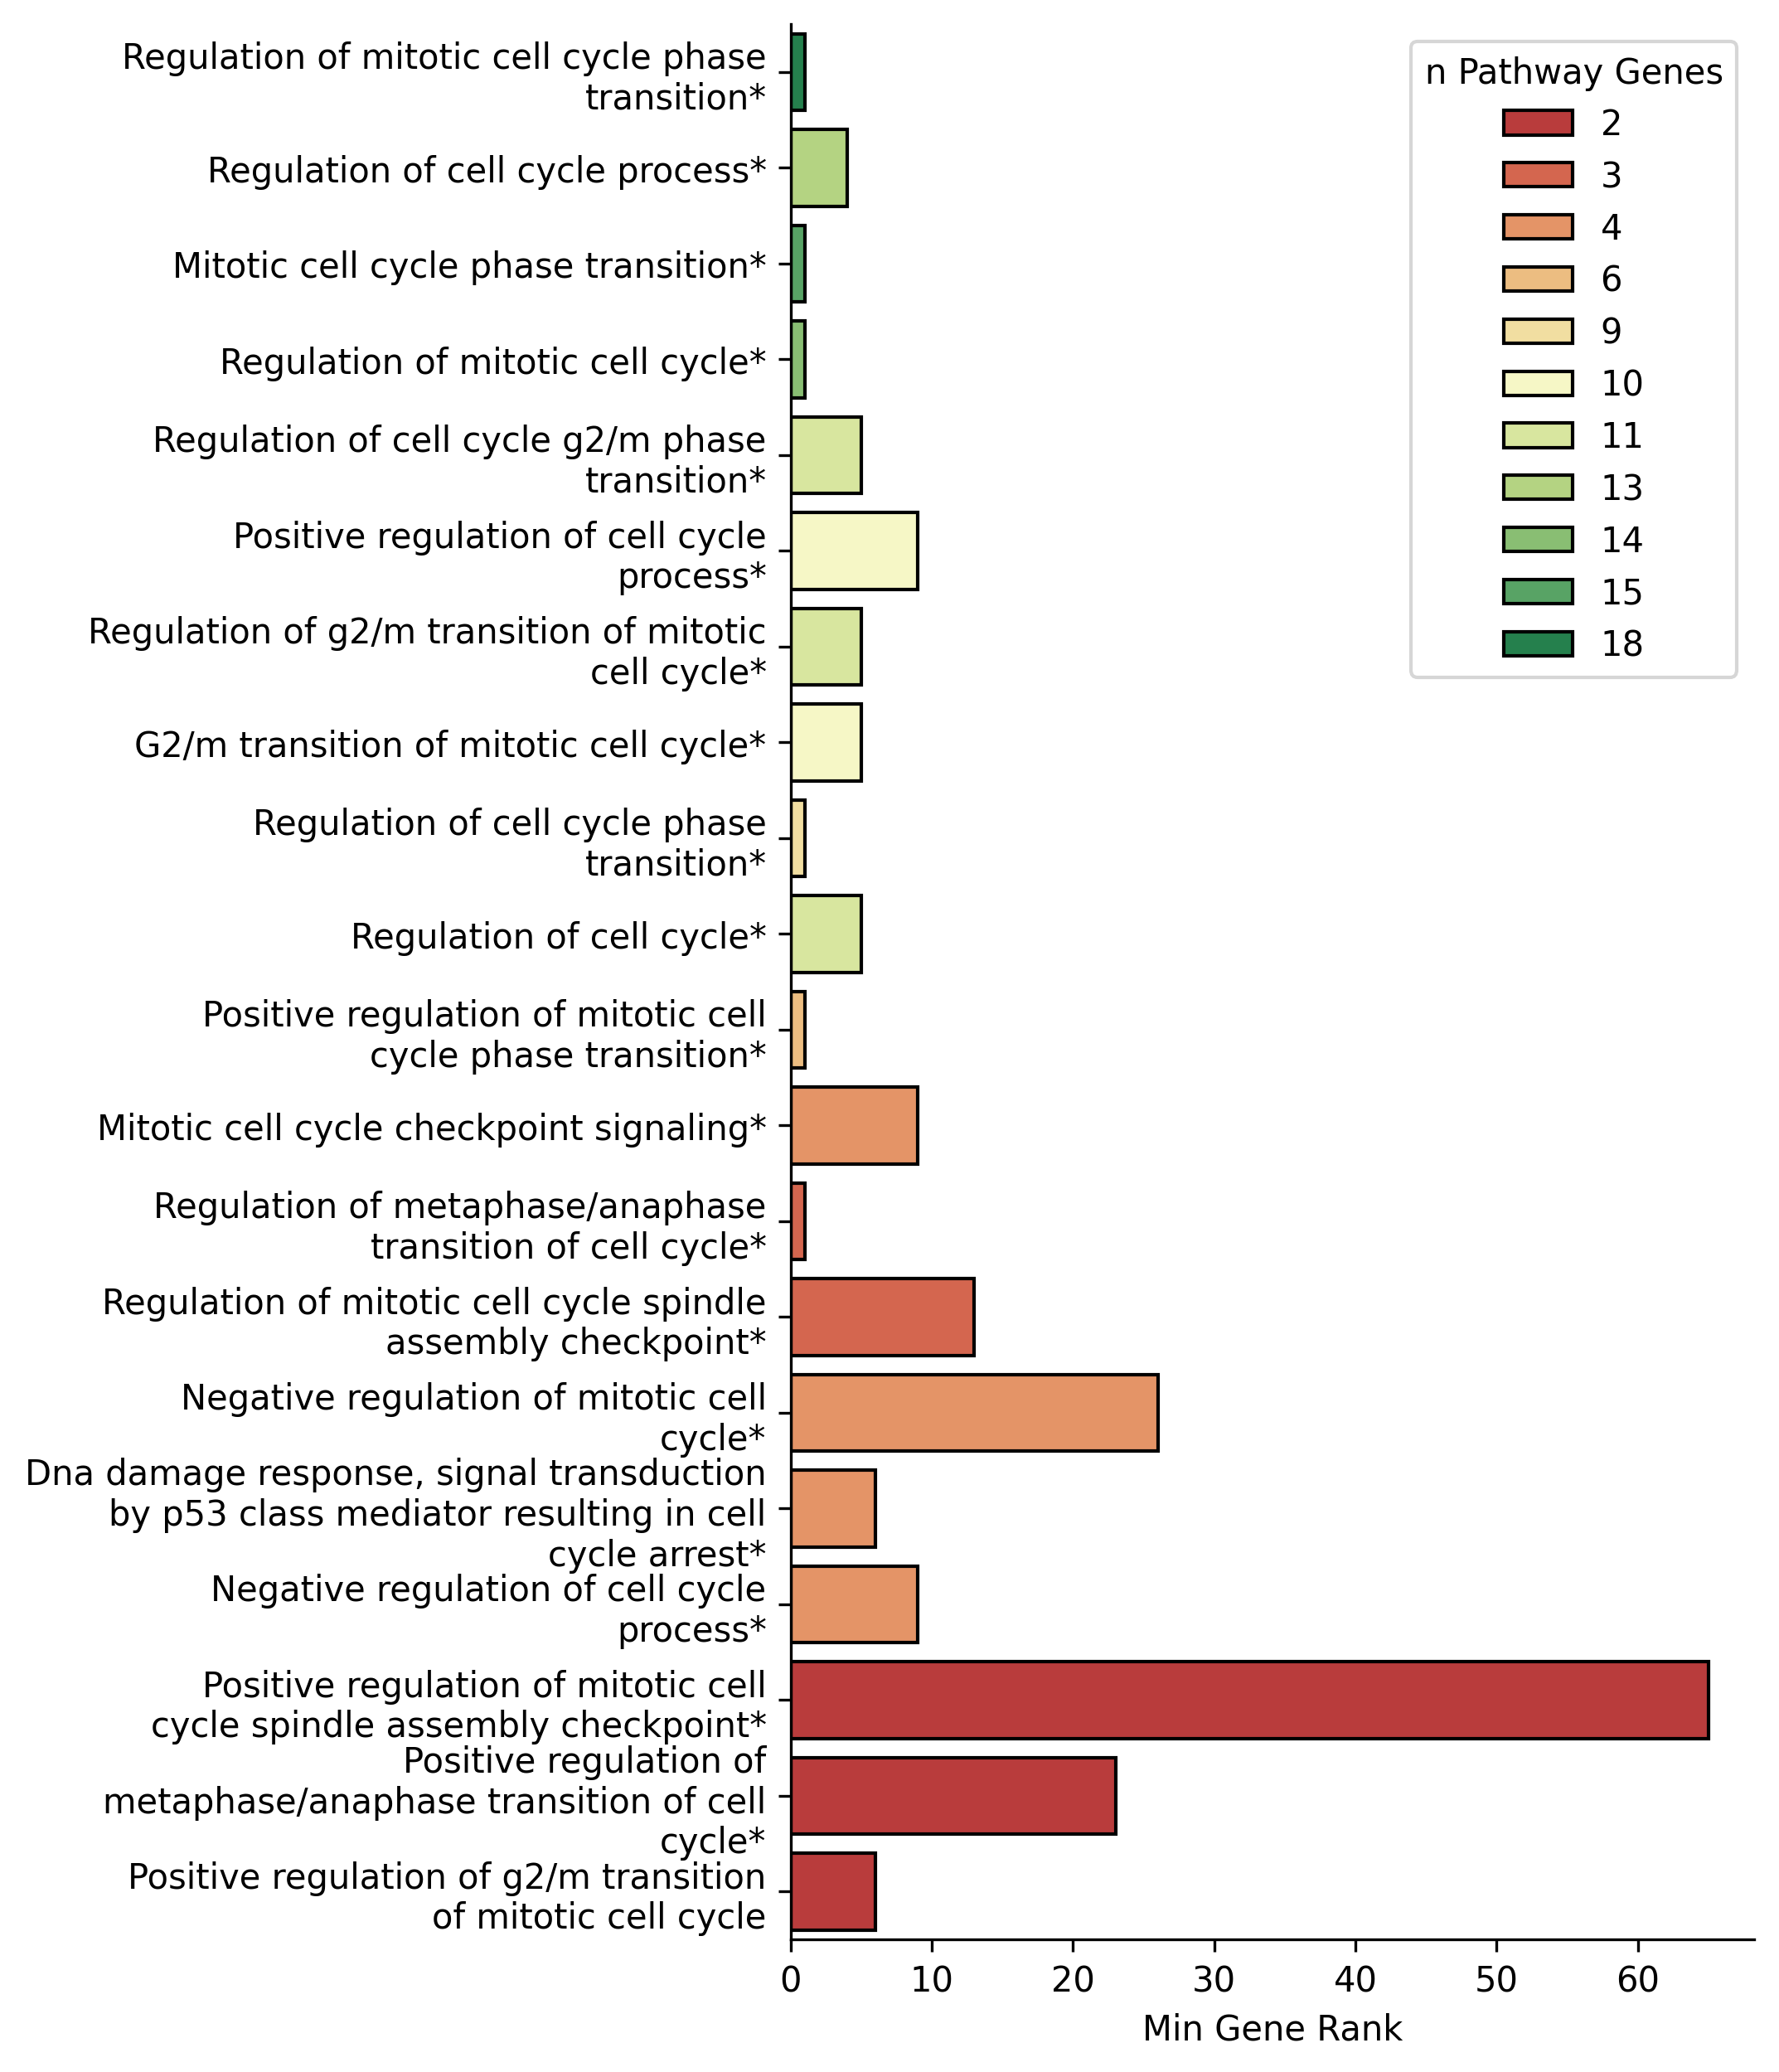

In [30]:
thresh = 0.01
pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
pdf['name_sig'] = pdf[['name', 'adj_p_val']].apply(lambda x: x[0].strip() + "*" if x[1] < thresh else x[0], axis=1)

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]

pdf['rank'] = pdf['overlapping_genes'].apply(lambda x: obs[obs['gene'].isin(x)]['rank'].min())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 10

sns.barplot(data=pdf.head(20), 
            y='name_sig',
            x='rank',
            hue='n_gene',
            dodge=False,
            ec='k',
            palette='RdYlGn')

plt.ylabel("")
plt.xlabel("Min Gene Rank")
wrap_ylabels(plt.gca(), width=40)
sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                title='n Pathway Genes')
pdf.head()

In [31]:
# break

# State estimation

In [32]:
## state estimation
rep = 0
t = 7 # not including the initial condition
x0 = dmd_data[:, 0, rep]
A = dmd_res['A']

Kt = []

for i in np.arange(0, t):
    print(f"Computing A^{i}...")
    At = np.linalg.matrix_power(A, i)
    Kt.append(At)

print('done')

Computing A^0...
Computing A^1...
Computing A^2...
Computing A^3...
Computing A^4...
Computing A^5...
Computing A^6...
done


In [33]:
""" Build the observed data matrix: need to only index the sensors, or all?"""

def estimate_z0(n_sensors, nT, Kt, data, V):
    """A function to estimate the initial condition given:
        : n_sensors (int) the number of top sensors to select, given the principal eigenvector of the Gram matrix
        : nT (int): number of timepoints for which to construct the estimation. Bounded the len(Kt).
        : Kt (list of gene x gene array): The precomputed exponentiation of the learned dynamics from DMD 
        : data (gene x time): the original data for a single replicate
        : V : the eigenvectors of the Gram matrix (columns are eigenvectors)
    """
    # get the gene sampling wieghts and select sensors
    q1 = np.abs(np.real(V[:,0]))
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]

    # compute the measurements and the esitmated dynamics, given the 
    # selected sensors
    # outputs
    yt = []
    O = []
    for i in np.arange(0, nT):
        # print(i)
        yt.append( np.dot(w, data[:, i]))
    
        if i == 0:
            O.append(w)
        else:
            wKt = np.dot(w, Kt[i])
            O.append(wKt)

    yt = np.asarray(yt)
    O = np.asarray(O)
    # print(f"{yt.shape=} {O.shape=}")
    z0 = np.dot(np.linalg.pinv(O), yt)
    return z0
    
n_sensors = 10
nT = 7
data = dmd_data[:, :, 1]
z0 = estimate_z0(n_sensors, nT, Kt, data, V)

np.linalg.norm(z0 - x0)

18790.377730172775

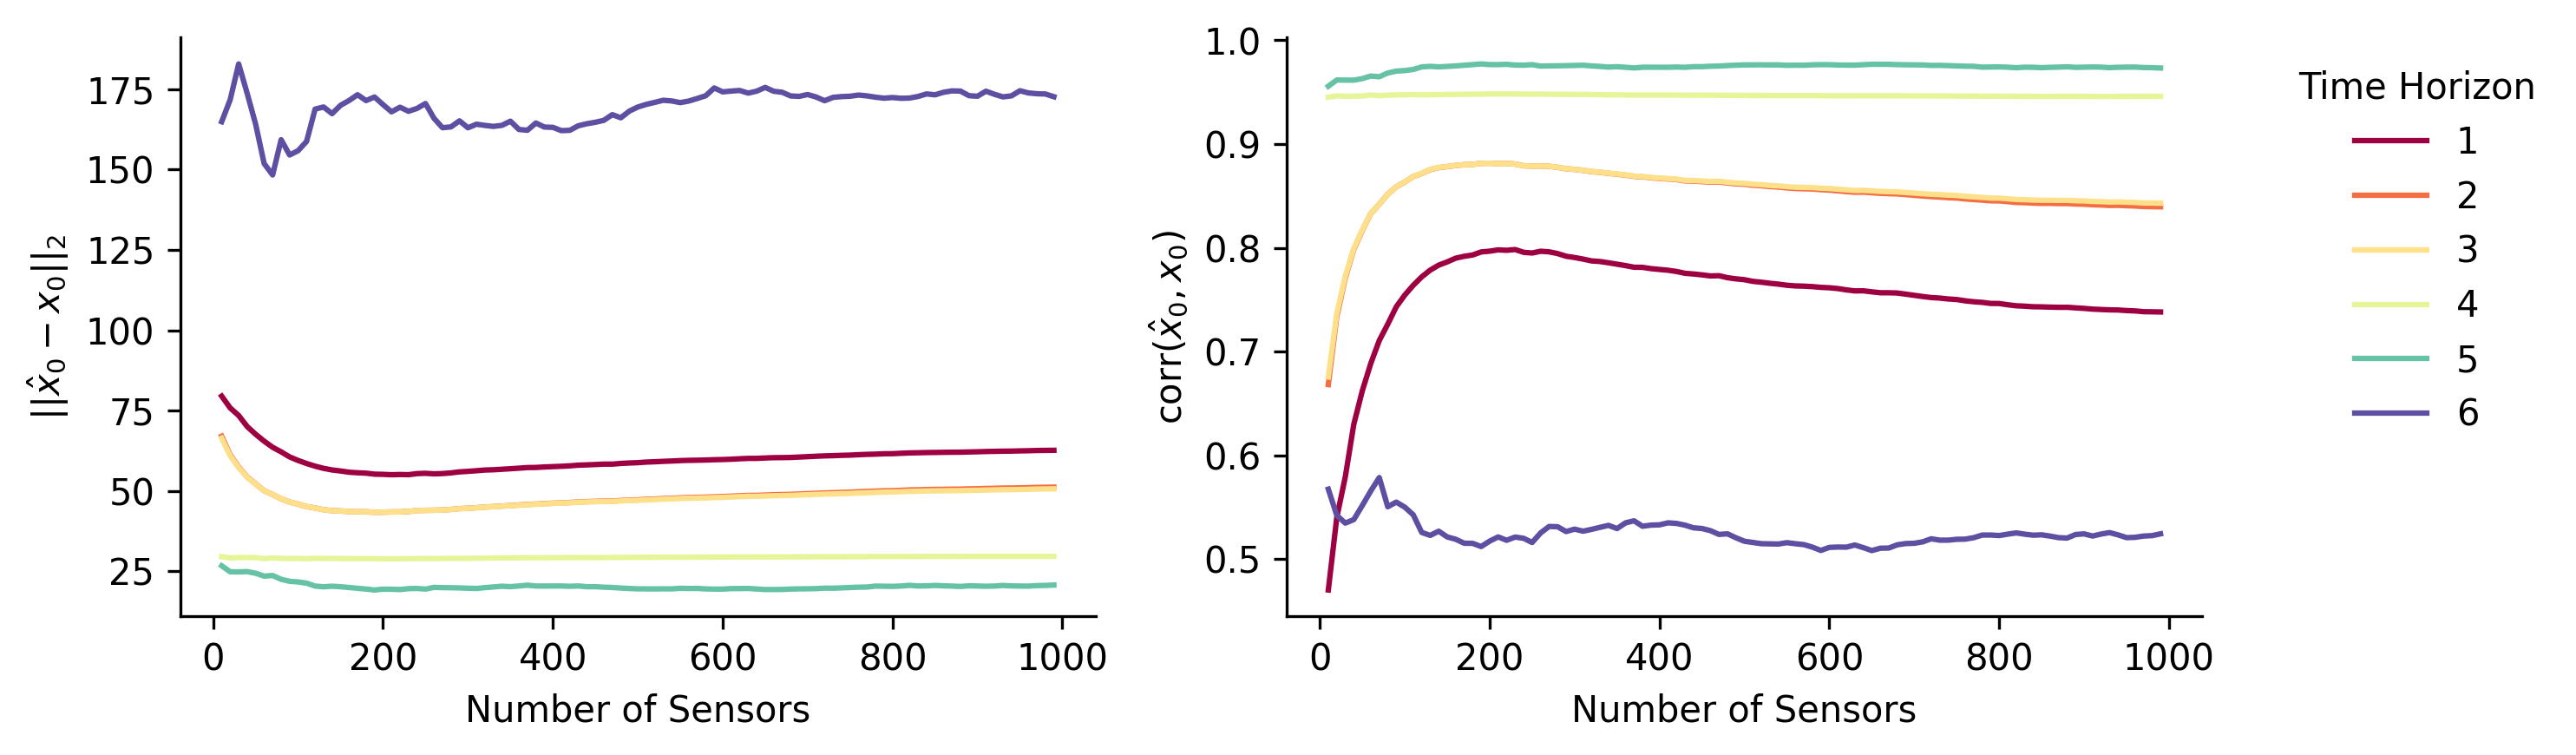

In [34]:
nT = 7
data = dmd_data[:, :, 0]

res = []
diffs = []

for n_sensors in np.arange(10, 1000, step=10):
    for nT in np.arange(1, 7):
        z0 = estimate_z0(n_sensors, nT, Kt, data, V)
        score, pval = scipy.stats.pearsonr(z0, x0)
        l2 = np.linalg.norm((z0-x0))
    
        diff = z0 - x0
        diffs.append(diff)
        
        row = {
            'n_sensors' : n_sensors,
            'corr' : score,
            'pval' : pval,
            'norm' : l2,
            'nT' : nT,
        }
        res.append(row)
    
res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 3

cmap = 'Spectral'

fig, axs = plt.subplots(1, 2)

sns.lineplot(data=res, 
              x='n_sensors',
              hue='nT',
              ax=axs[0],
              palette=cmap,
              y='norm')

axs[0].set_ylabel(r"$||\hat{x}_0 - x_0||_2$")
axs[0].set_xlabel("Number of Sensors")
axs[0].legend().remove()

sns.lineplot(data=res, 
              x='n_sensors',
              hue='nT',
              ax=axs[1],
              palette=cmap,
              y='corr')

axs[1].set_ylabel(r"corr$(\hat{x}_0, x_0)$")
axs[1].set_xlabel("Number of Sensors")

sns.move_legend(axs[1],
                loc='upper right',
                frameon=False,
                title='Time Horizon',
                bbox_to_anchor=(1.4, 1))

sns.despine()
plt.tight_layout()

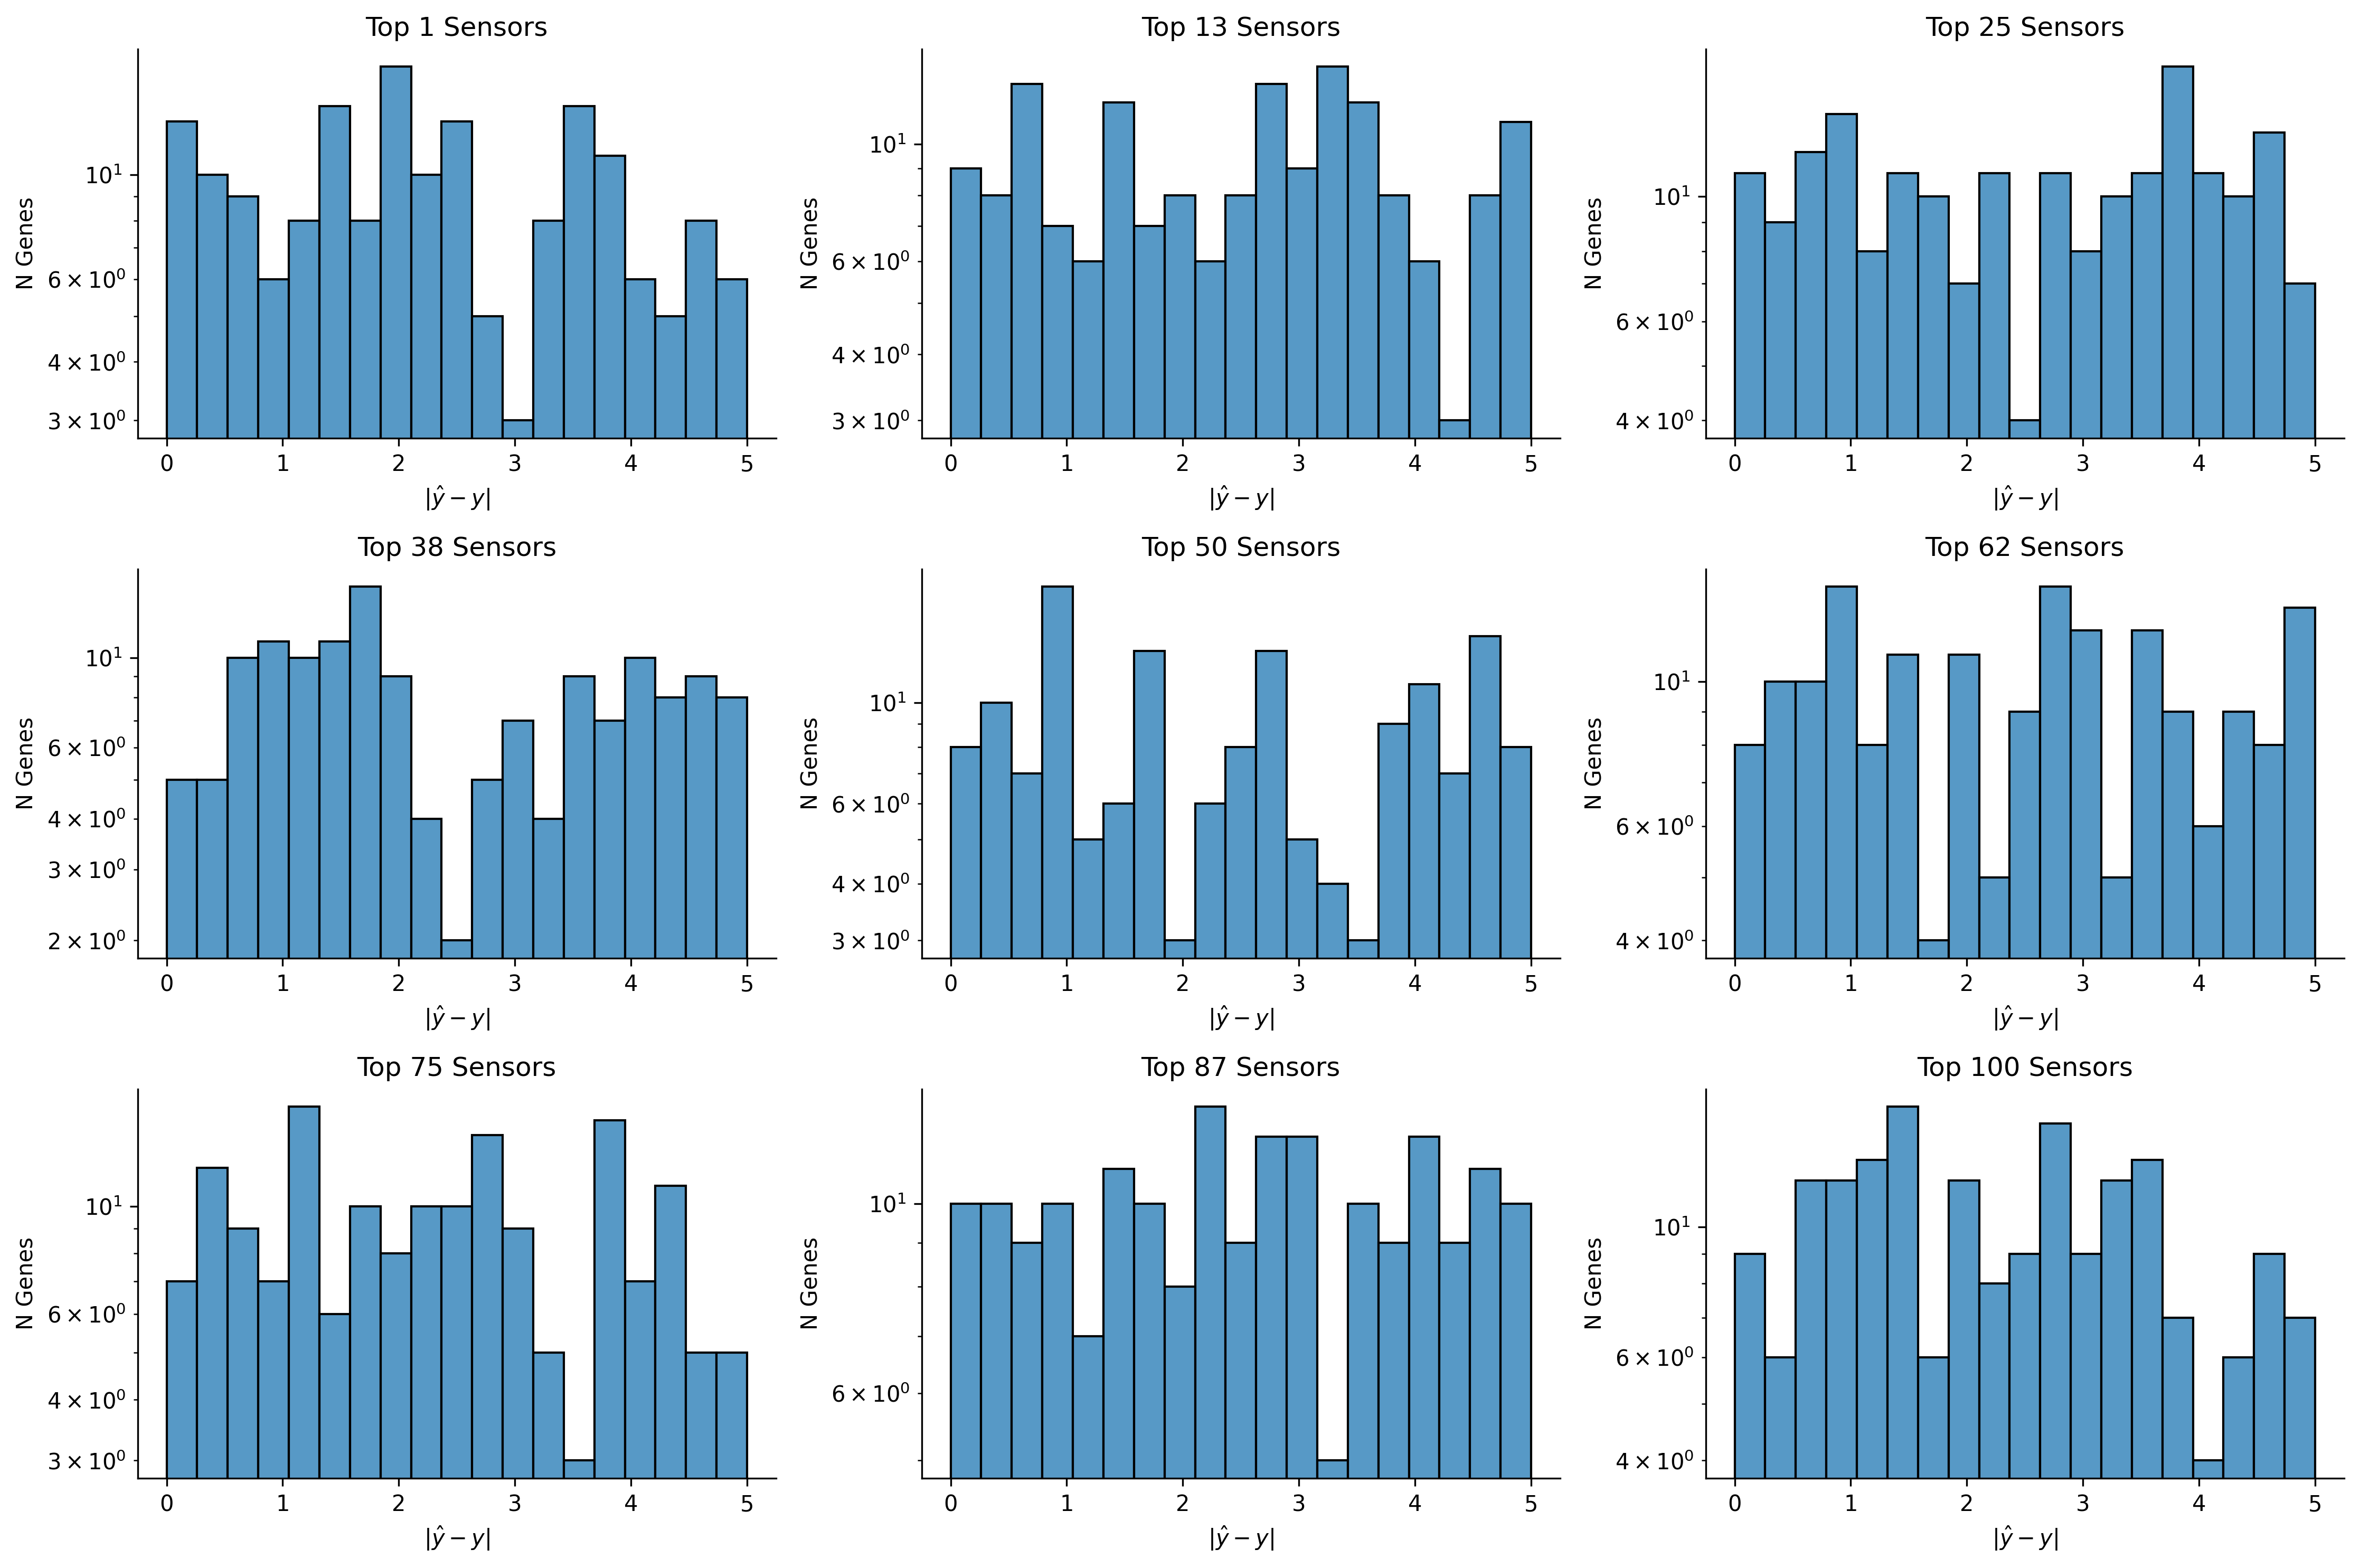

In [35]:
nT = 7
data = dmd_data[:, :, 0]
n = 9 # number of plots

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 10
fig, axs = plt.subplots(3, 3)
axs = axs.ravel()


for i, n_sensors in enumerate(np.linspace(1, 100, n).astype(int)):
    z0 = estimate_z0(n_sensors, nT, Kt, data, V)

    diff = np.abs(z0 - x0)

    sns.histplot(diff, 
                 bins=np.linspace(0, 5, 20),
                 ax=axs[i])
    
    axs[i].set_yscale('log')
    axs[i].set_ylabel('N Genes')
    axs[i].set_xlabel(r'$|\hat{y} - y$|')
    axs[i].set_title(f"Top {n_sensors} Sensors")


plt.tight_layout()
sns.despine()

In [36]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def select_sensors(V, n_sensors=10):
    q1 = np.abs(np.real(V[:,0]))
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]
    return w
    

def reconstruct_x0(data,nT,A,C):
    '''
    The matrix C should be of shape (pxn) if the data are shape (nxm) for p measured genes, n total genes, and m samples
    If p << n, leave only entries of C that correspond to the p genes as nonzero.
    '''
    # generate outputs at nT timepoints, check rank of O_T, and estimate IC
    O_T = np.zeros((len(C)*nT,C.shape[1])) # O_T has dim p*nT x n
    for ii in range(O_T.shape[0]): # observability matrix
        O_T[ii] = C @ np.linalg.matrix_power(A,ii)    

    # use the learned dynamics and sampling to generate output over time
    y = np.zeros((len(C),nT)) 
    for ii in range(nT):
        y[:,ii] = C @ np.linalg.matrix_power(A,ii) @ data[:,0]

    # estimate of x0 
    x0_est = np.linalg.pinv(O_T) @ y.T

    return x0_est


n_sensors = 10
C = select_sensors(V, n_sensors=10)
C = np.expand_dims(C, axis=0)
nT = 3
data = dmd_data[:, :, 0]
x0 = dmd_data[:, 0, 0]
A = dmd_res['A']

z0 = reconstruct_x0(data, nT, A, C)

l2 = np.linalg.norm(z0 - x0)
score, pval = scipy.stats.pearsonr(np.squeeze(z0), x0)
print(f"{n_sensors=} {nT=} {l2=} {score=} {pval=}")

In [ ]:
# get the sensors
w = np.real(V[:,0])
ind = np.argpartition(w, -n_sensors)[-n_sensors:]
w_bin = np.zeros(w.shape)
w_bin[ind] = w[ind]

print(np.asarray(gene_names)[ind])

yt_true = dmd_data[:, t-1, rep] # t-1 for index offset
A = dmd_res['A']

print(f"{A.shape=} {x0.shape=} {w.shape=} {yt_true.shape=}")

At = np.linalg.matrix_power(A, t)
print(f"{At.shape=}")

In [ ]:
# get the sensors
n_sensors = 100
w = np.real(V[:,0:n_sensors])
C = np.zeros(w.shape)

row_ind = np.argpartition(w[:, 0], -n_sensors)[-n_sensors:] # leading eigenvector
col_ind = np.arange(0, n_sensors)

C[row_ind, col_ind] = 1
print(f"{C.shape=} {C.sum()=}")

yt_pred = np.dot(C.T, np.dot(At, x0))
print(f"{yt_pred.shape=} {yt_true.shape=} {yt_true[row_ind].shape=}")

# print()
# print(yt_true[ind])
# print()
# print(yt_pred)
# print()

np.corrcoef(yt_true[row_ind], yt_pred)


In [ ]:
np.corrcoef(yt_true[ind], test)

In [ ]:
test